# Long Only SMA (Close)

Open long position at the days 'open' price if yesterdays short term sma rises above long term sma. Must consult yesterdays sma values as they are calculated on daily close prices. Therfore, the current days' daily sma values are not yet calculated.

In [1]:
# Import packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mlt
import seaborn as sns
sns.set()
mlt.rcParams['font.family'] = 'sans-serif'
import mplfinance as mpf

# Constants
sma = [40,250]
sma_type = 'Close' # or 'Open'
csv = '1a - results/data1.csv'
charts = '1a - results/charts/'
#quarterlies = '1a - results/charts/quarters/'

pairs = []
if len(sma) > 2:
    for i in sma:
        right_slice = sma[i:]
        for ii in right_slice:
            pairs.append((i,ii))
elif len(sma) == 2:
    pairs.append((sma[0],sma[1]))
print(pairs)

# Define summary performance csv layout
output_df = pd.DataFrame(
    columns=['SMAs','Test Period','Max DD%','DD Freq','Trades','Return Multiple','Percentage Change','Buy and Hold Percentage Change']
)

# Test periods
#start1 = pd.Timestamp(year=2015,month=2,day=1,tz='UTC')
#start1 = pd.Timestamp(year=2015,month=4,day=5,tz='UTC')
#end1 = pd.Timestamp(year=2018,month=1,day=1,tz='UTC')

#start2 = pd.Timestamp(year=2019,month=2,day=1,tz='UTC')
#end2 = pd.Timestamp(year=2021,month=11,day=1,tz='UTC')

start1 = pd.Timestamp(year=2014,month=9,day=17,tz='UTC')
end1 = pd.Timestamp(year=2023,month=1,day=24,tz='UTC')

test_periods =[
    [start1, end1]#,
    #[start2, end2]
]

[(1, 2), (1, 3), (1, 4), (1, 5), (1, 6), (1, 7), (1, 8), (1, 9), (1, 10), (2, 3), (2, 4), (2, 5), (2, 6), (2, 7), (2, 8), (2, 9), (2, 10), (3, 4), (3, 5), (3, 6), (3, 7), (3, 8), (3, 9), (3, 10), (4, 5), (4, 6), (4, 7), (4, 8), (4, 9), (4, 10), (5, 6), (5, 7), (5, 8), (5, 9), (5, 10), (6, 7), (6, 8), (6, 9), (6, 10), (7, 8), (7, 9), (7, 10), (8, 9), (8, 10), (9, 10)]


In [2]:
# Custom drawdown function - returns flat ndarray of percentage declines in time series
# price data. Accepts 1 parameter, pandas Series object. Other cellections may work too.
def findDrawDowns(series):
    i = 0
    drawdown_percentages = np.array([])
    while i < len(series):
        if i+1 < len(series) and series[i+1] < series[i]: # start of a price decline id'd
            peak_index = i # save peak index
            peak = series[i] # save peak value
            search_series = np.array(series[peak_index+1:]) # convert series to array, from values after peak to end
            try: # If remaining values make or match current peak, make end index
                end_index = int(np.argwhere(search_series >= peak)[0])
            except: # otherwise, make end of series the end index
                end_index = len(series)
            search_series = search_series[:int(end_index)] # Remove unnecessary search values, if any
            trough = np.min(search_series) # Get trough value
            percent_decline = ((peak - trough) / peak) * 100 # Calculate percentage drawdown
            drawdown_percentages = np.append(drawdown_percentages, percent_decline) # Save to array
            i += int(int(end_index)) # Resume search for next drawdown
        else:
            i += 1 # Resume search for next drawdown
    return drawdown_percentages

## Calculate rolling stats - SMAs
Produces a list of dataframes, one for each test period.

In [3]:
# Import price data
import yfinance as yf
btc = yf.Ticker("BTC-USD")
#sma = range(1,201)
df_list = []
hodl = []

for period in test_periods:
    df = btc.history(
        #start = period[0] - pd.Timedelta(days=sma[-1]),
        start = period[0]
        end = period[1]
    )
    hodl.append(
        round(((df['Close'][-1] - df['Close'][0])/df['Close'][0])*100,2)
    )
    sma_columns = [df[sma_type].rolling(k).mean().rename(f'sma_{k}') for k in sma]
    df = pd.concat([df] + sma_columns, axis=1)
    df = df.drop(columns=['Dividends', 'Stock Splits'])
    df['Trades'] = 0
    df = df.loc[period[0]:period[1]]
    df_list.append(df)

## Pseudocode

In [4]:
# for each test period:
    # for each sma pair:
        # for each row, starting on the second:
            # if sma[0] rises above sma[1]: # bull signal
                # if long already open:
                    # pad time series
                    # ...
                # if no long positon open:
                    # open long

            # if sma[0] falls bellow sma[1]: # bear signal
                # if long not open:
                    # pad time series
                # if long postion open:
                    # close long
        
        # Chart returns
        # ...

## Run the strategy, plot return.

/Users/andrew/opt/anaconda3/lib/python3.9/site-packages/pandas/plotting/_matplotlib/core.py:386: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)


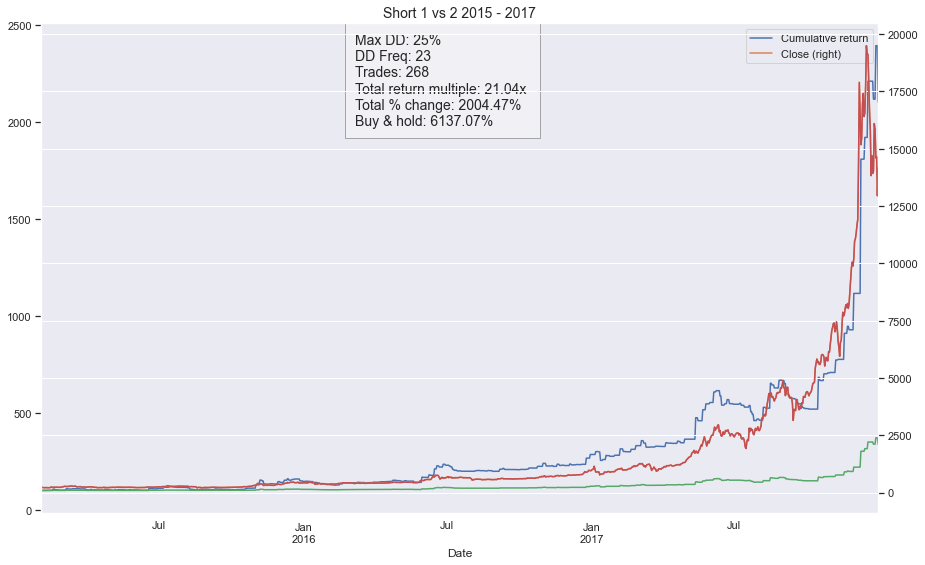

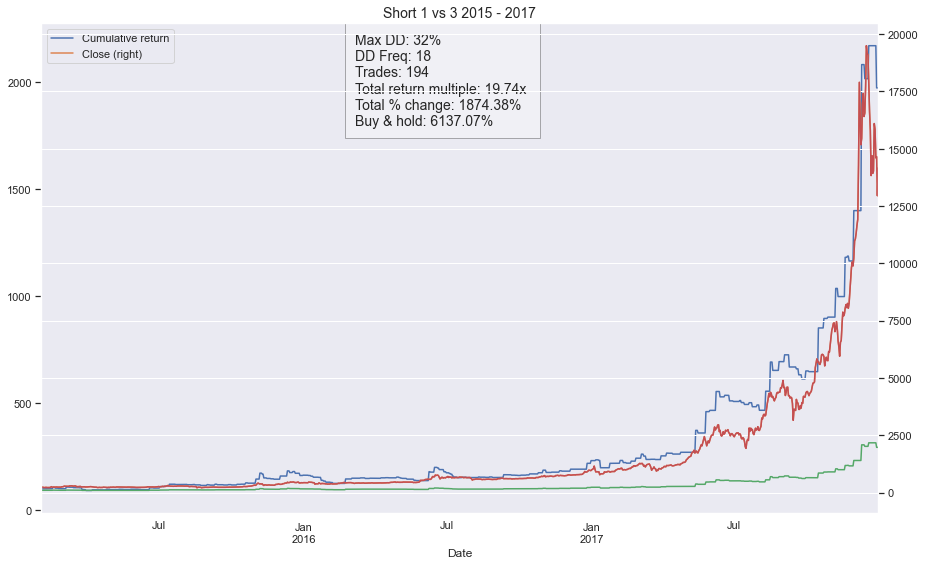

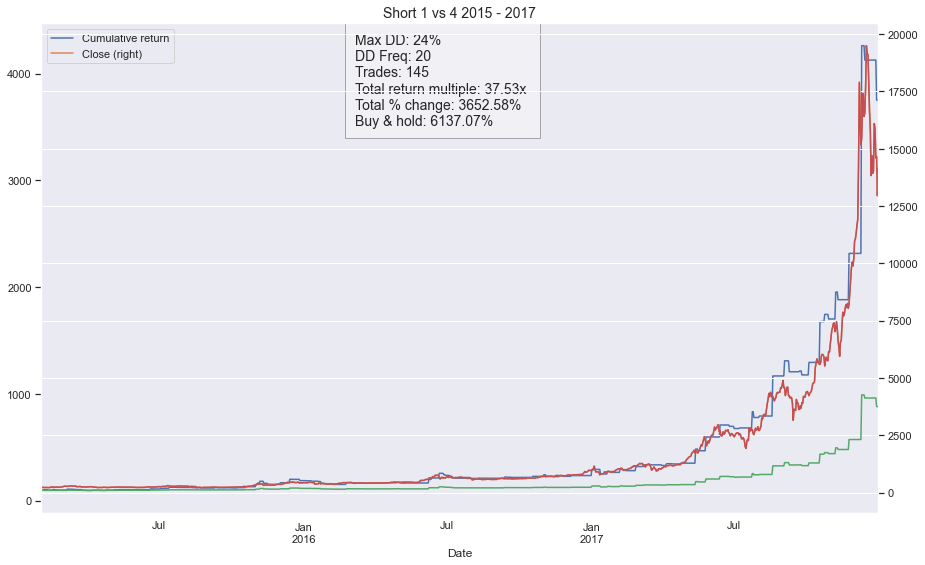

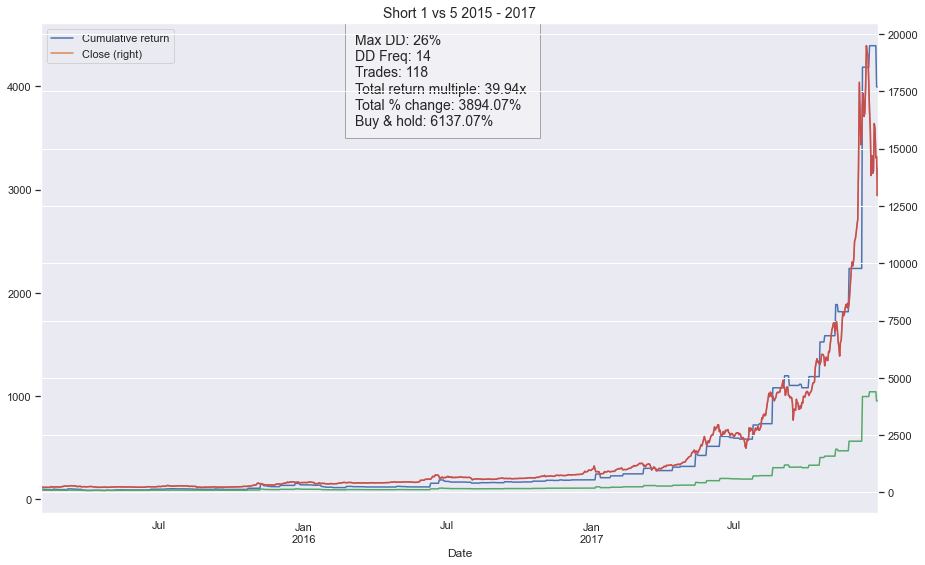

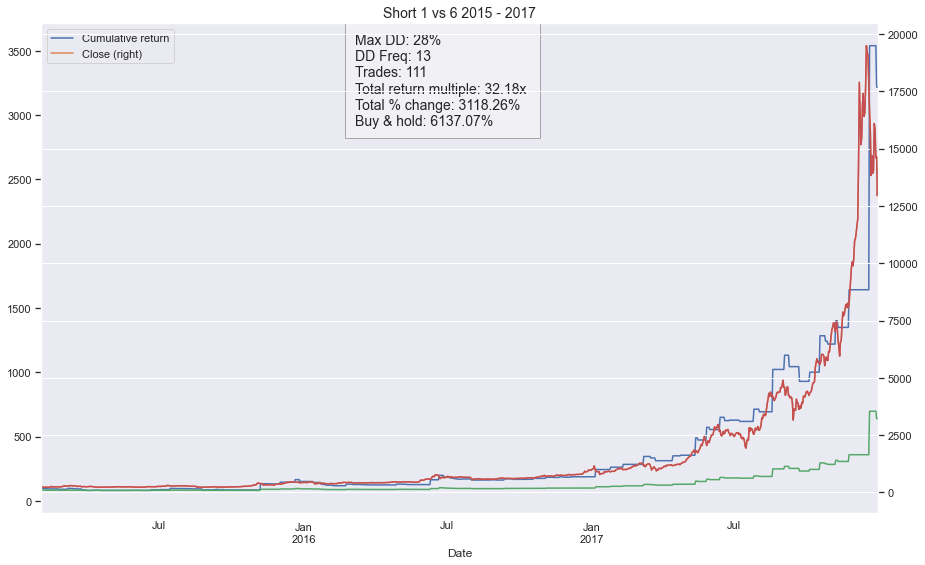

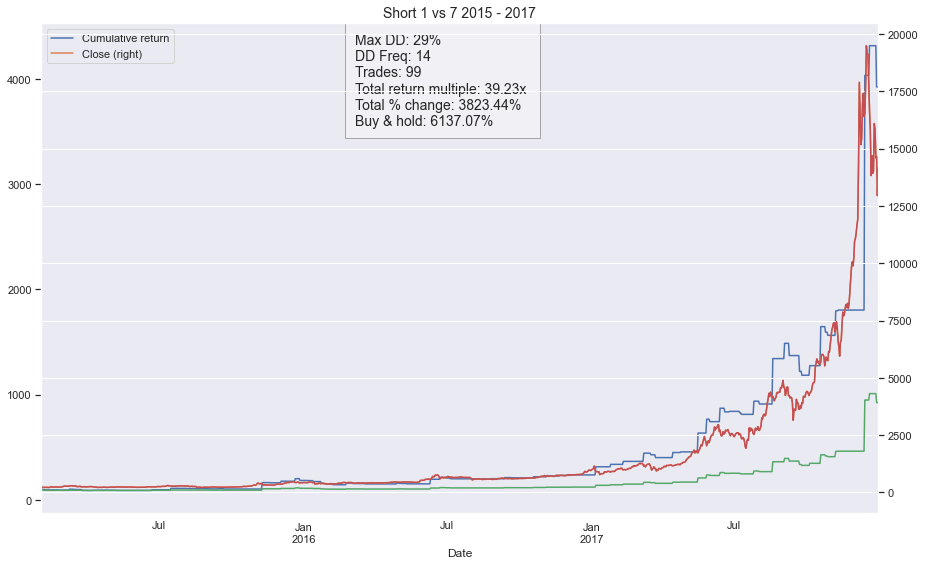

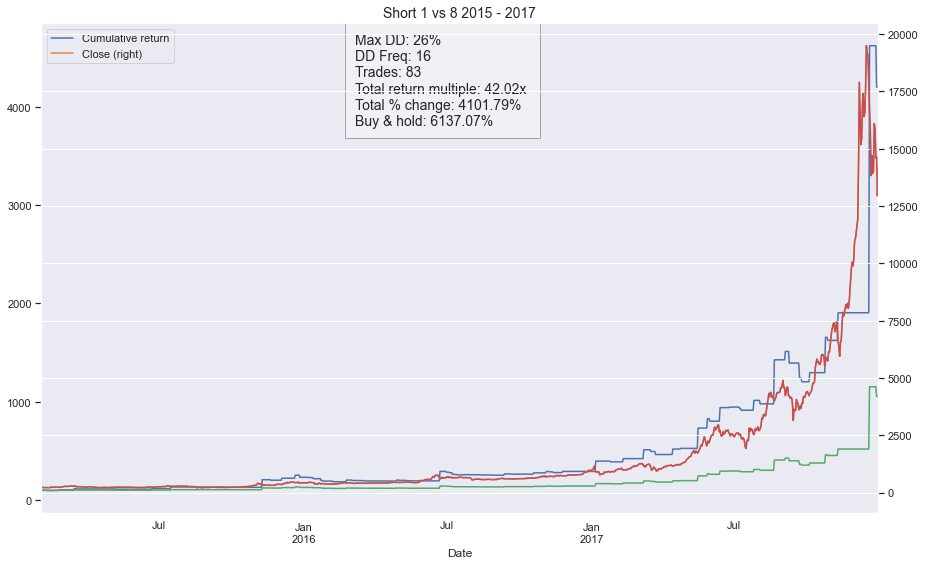

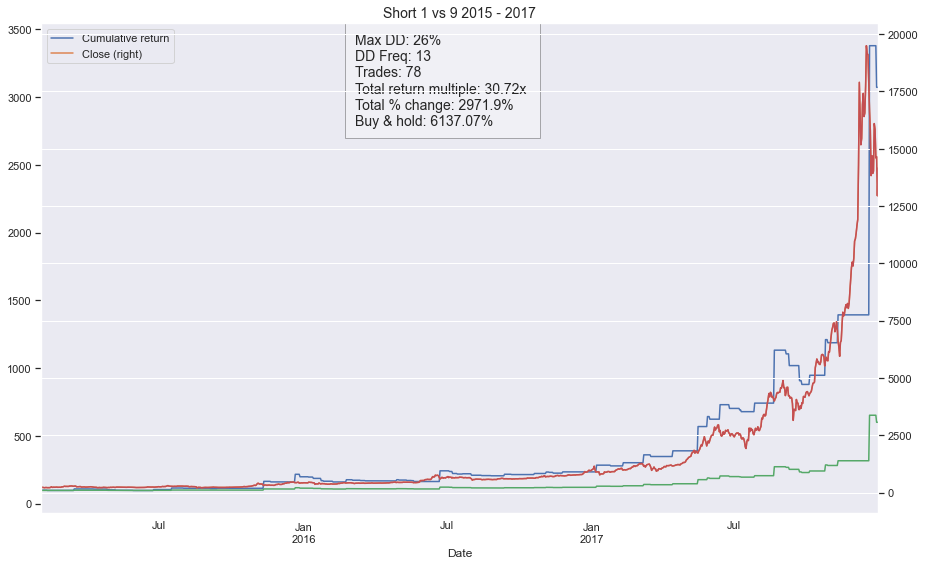

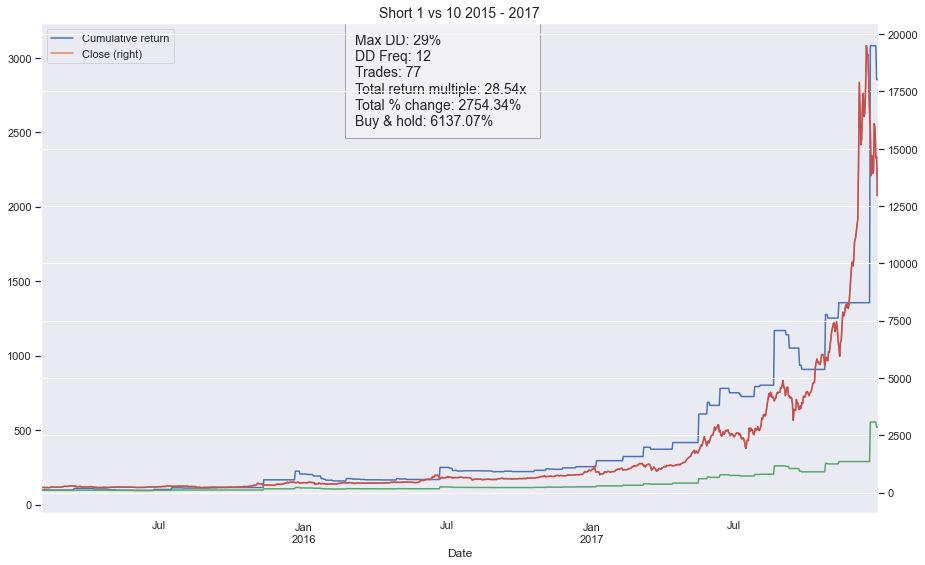

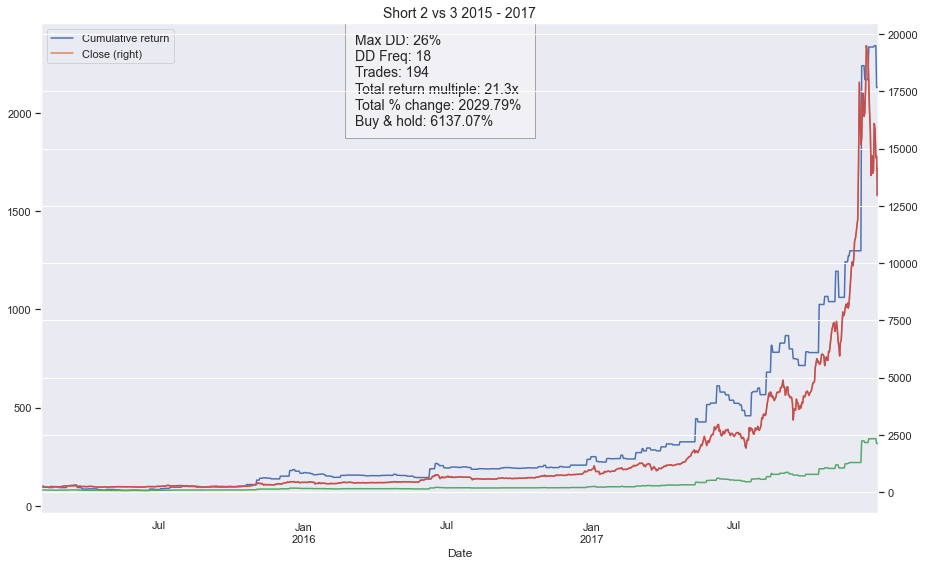

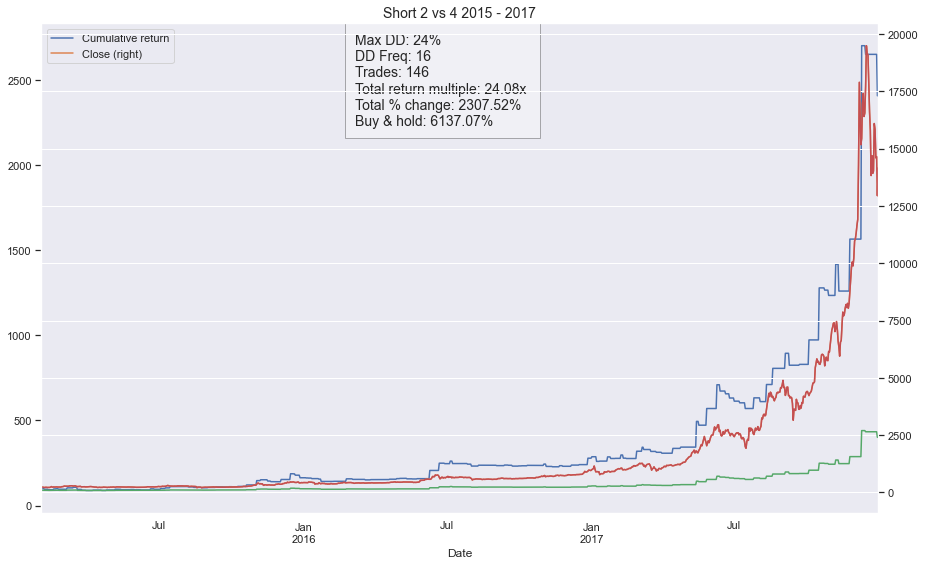

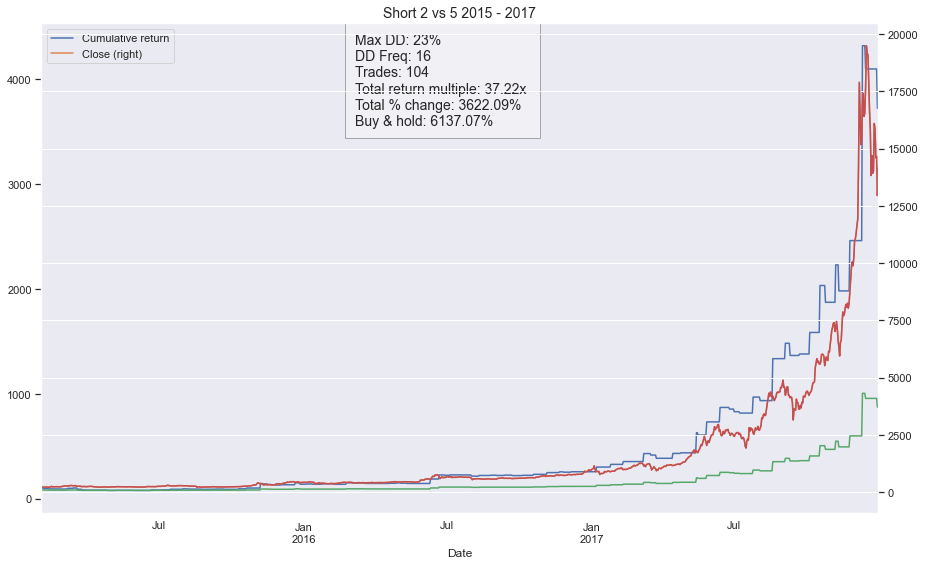

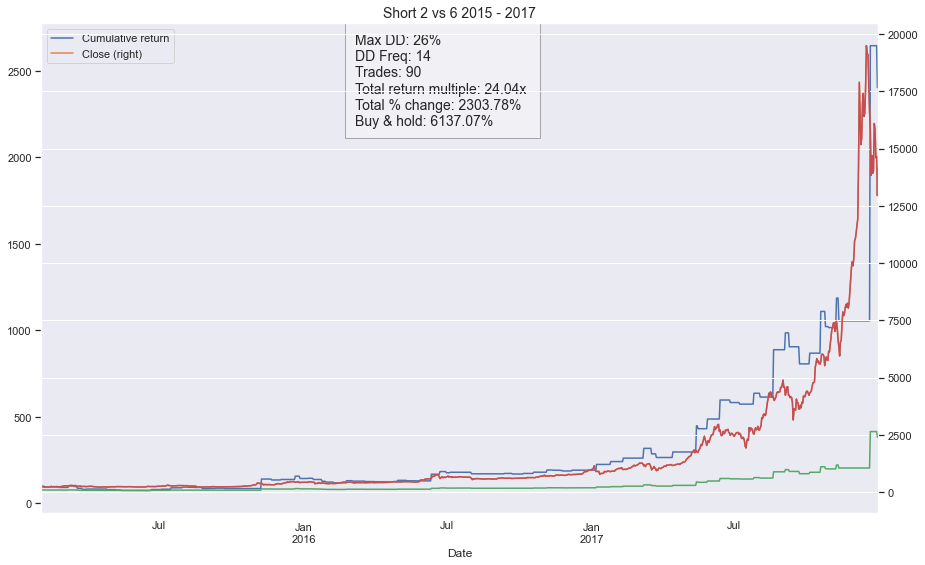

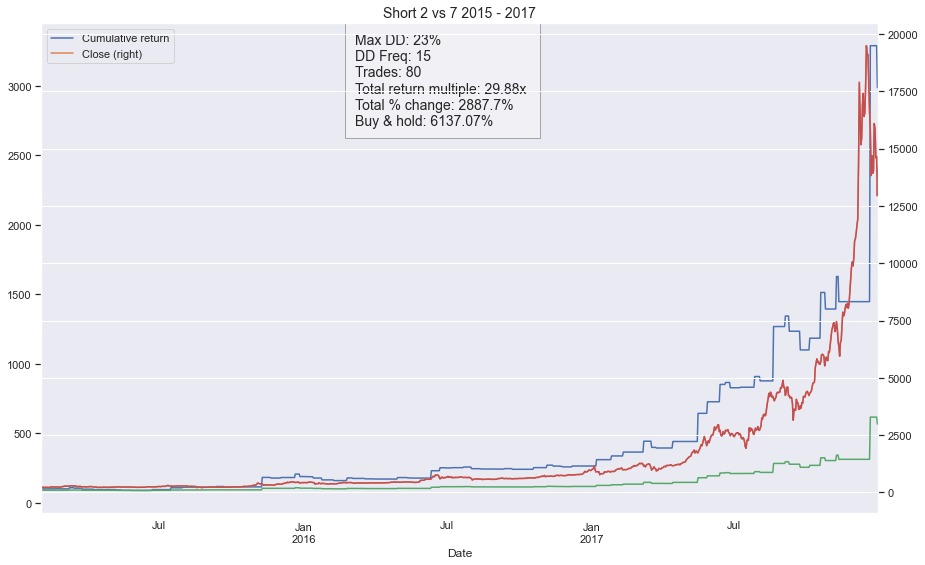

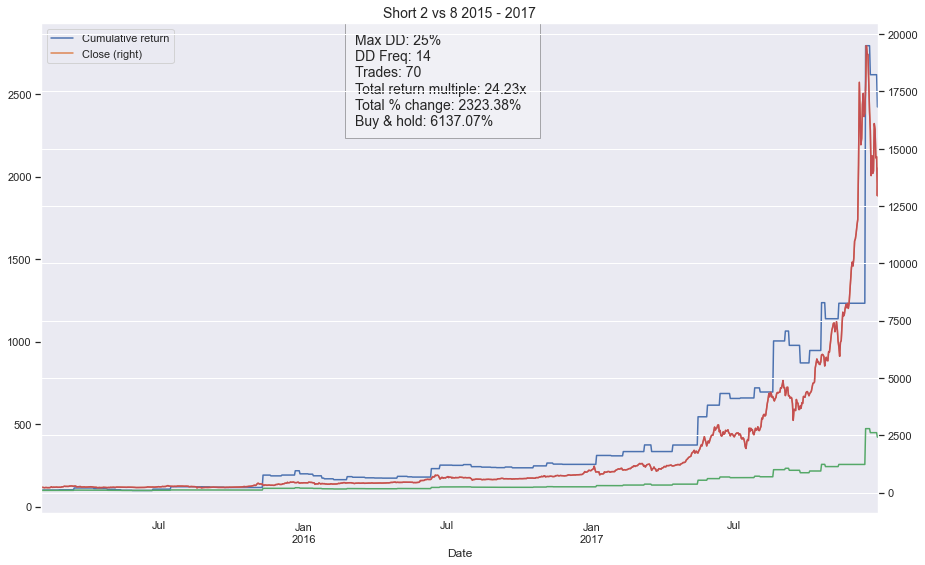

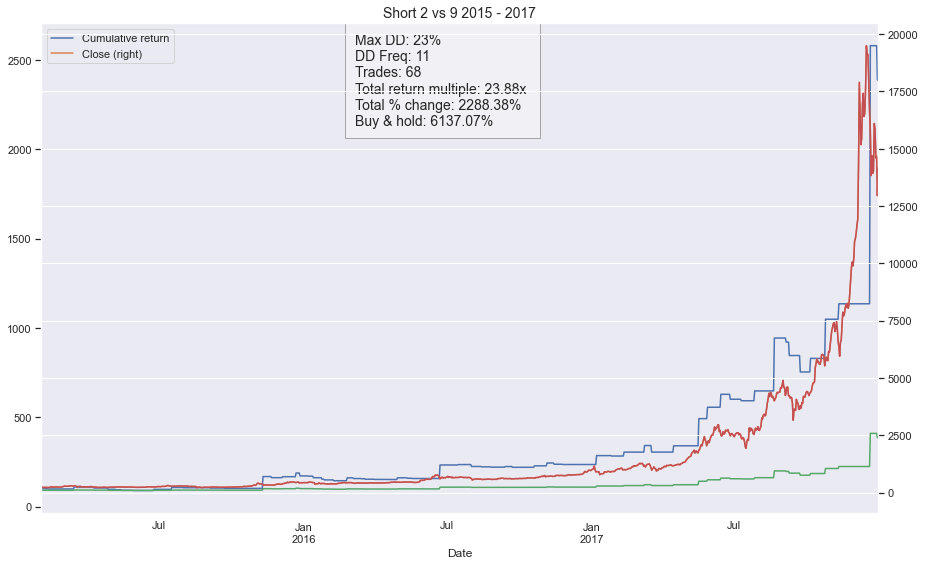

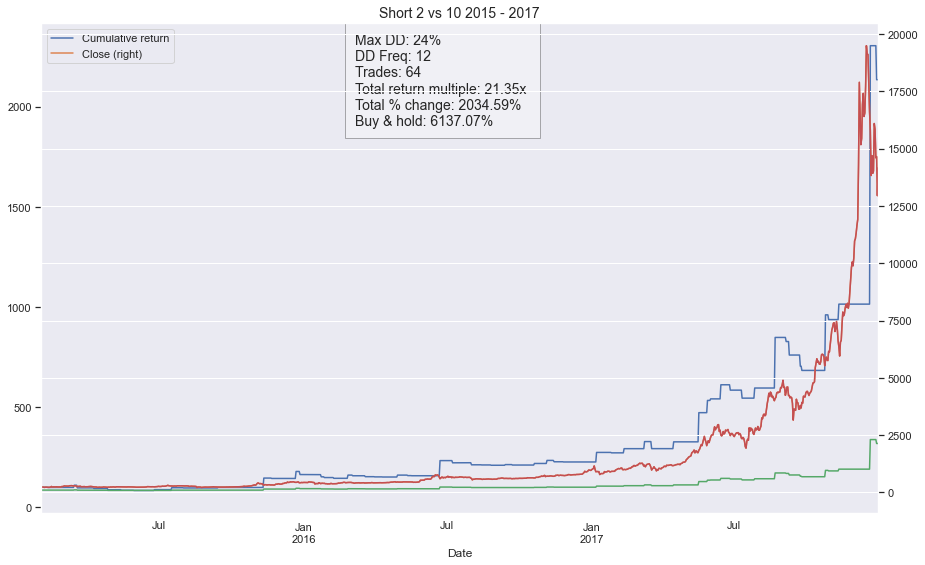

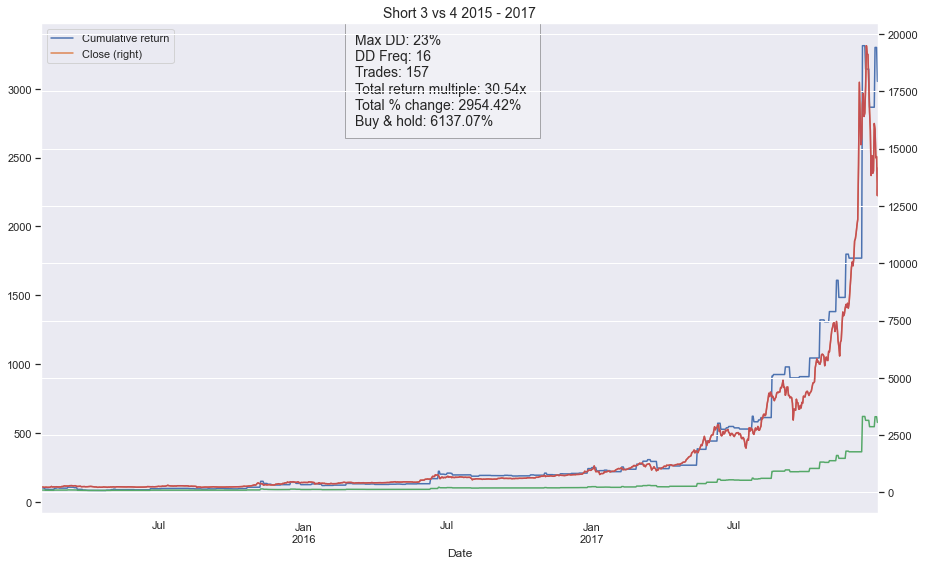

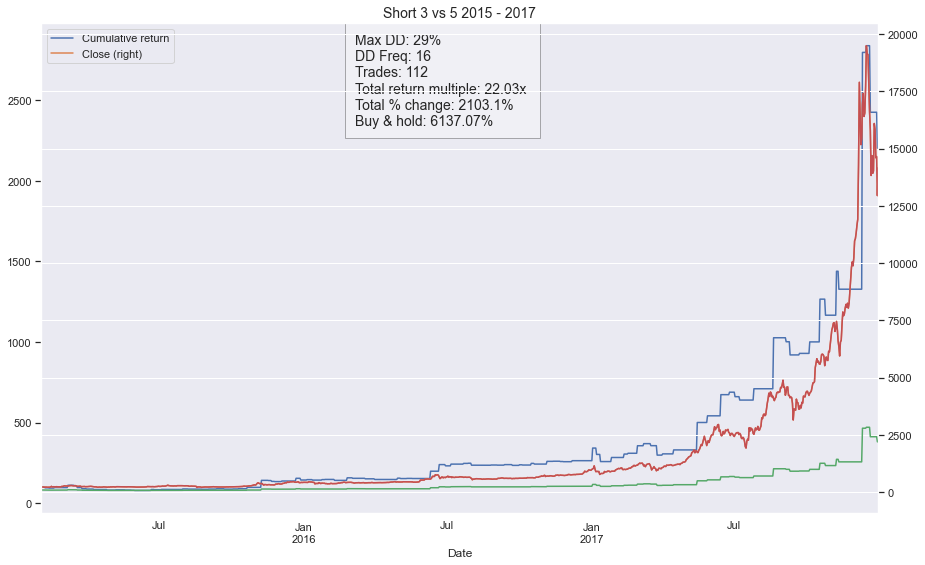

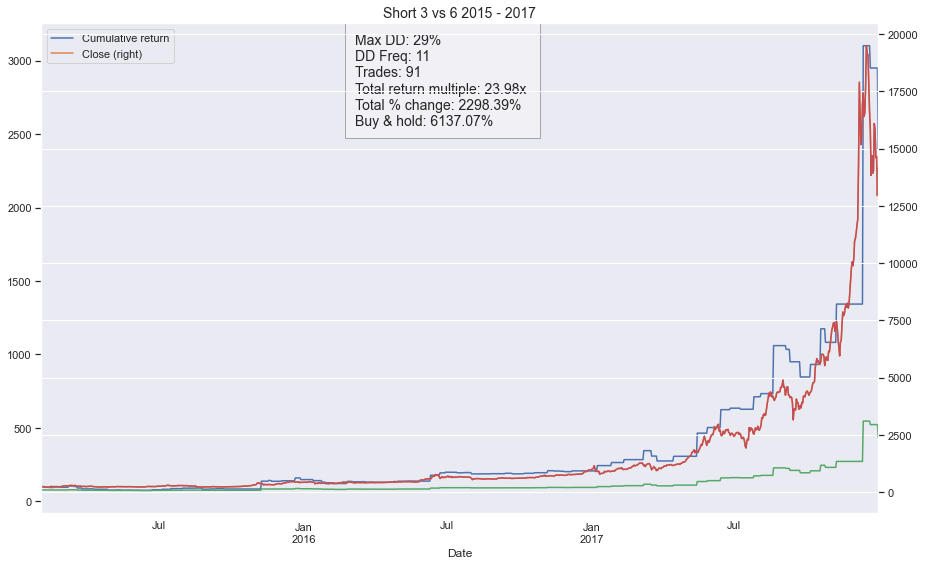

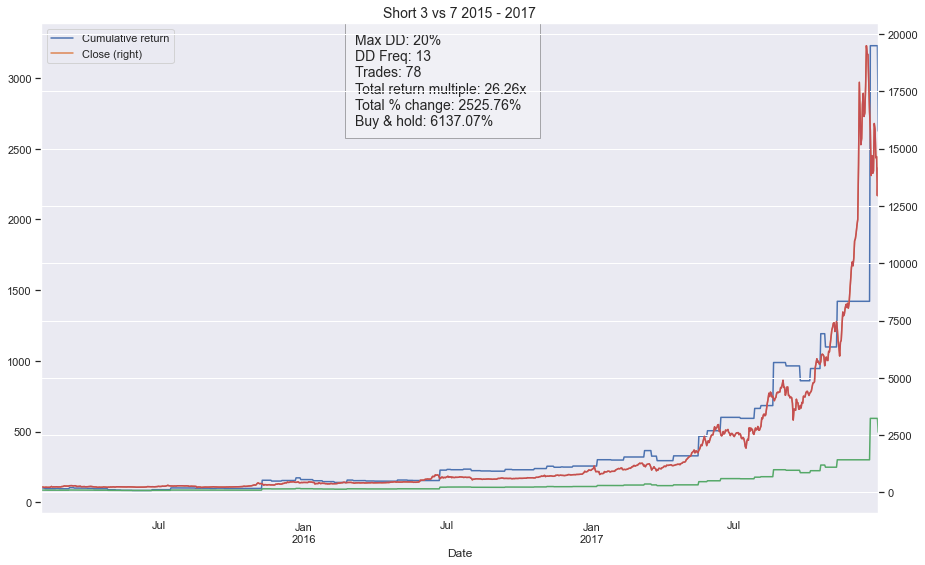

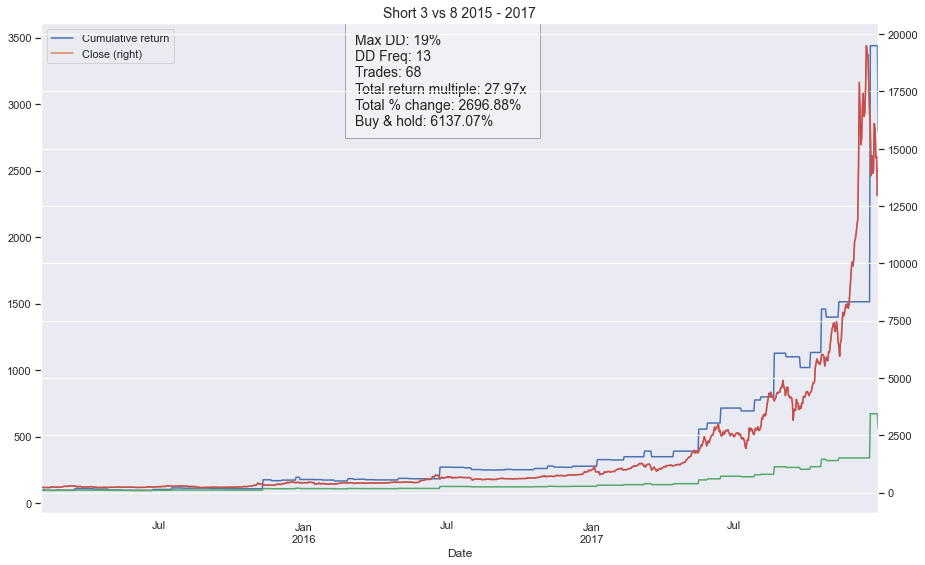

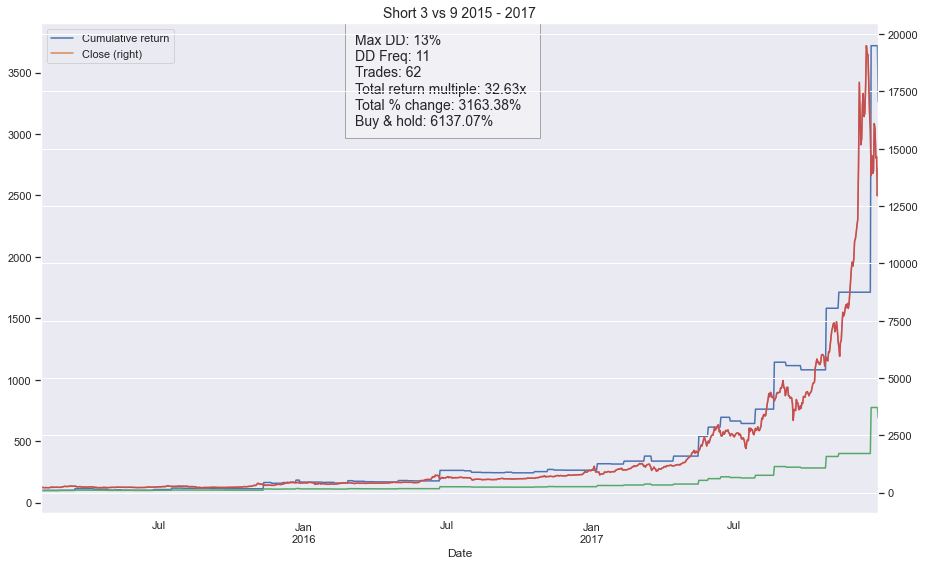

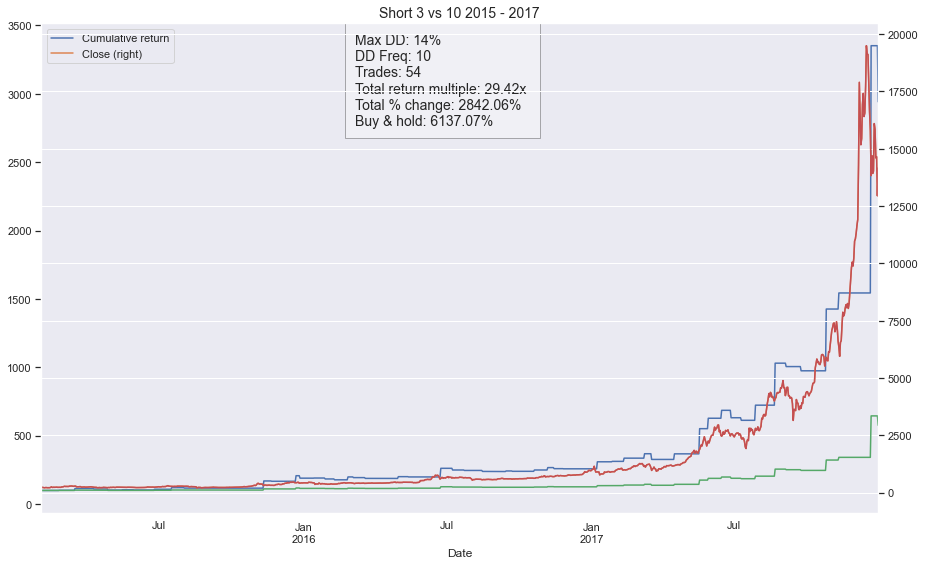

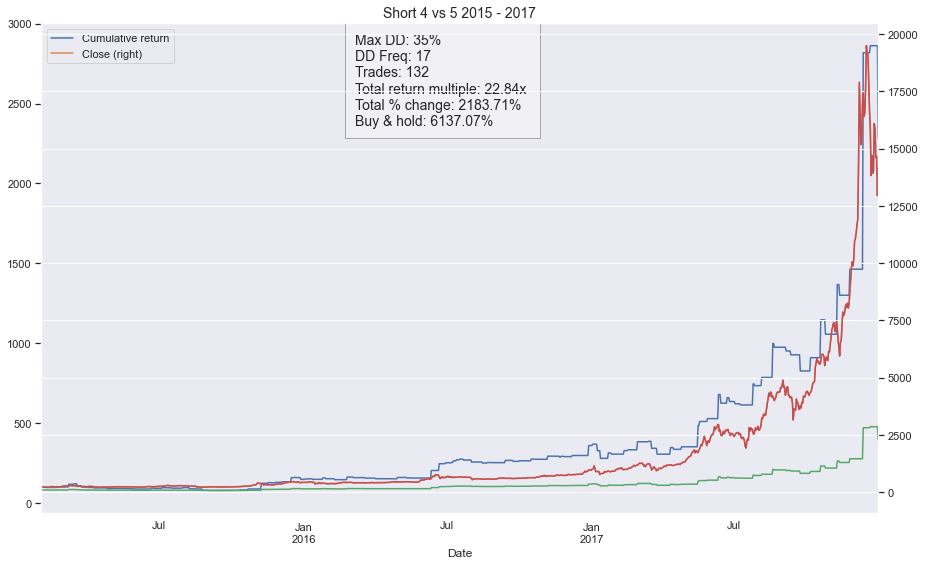

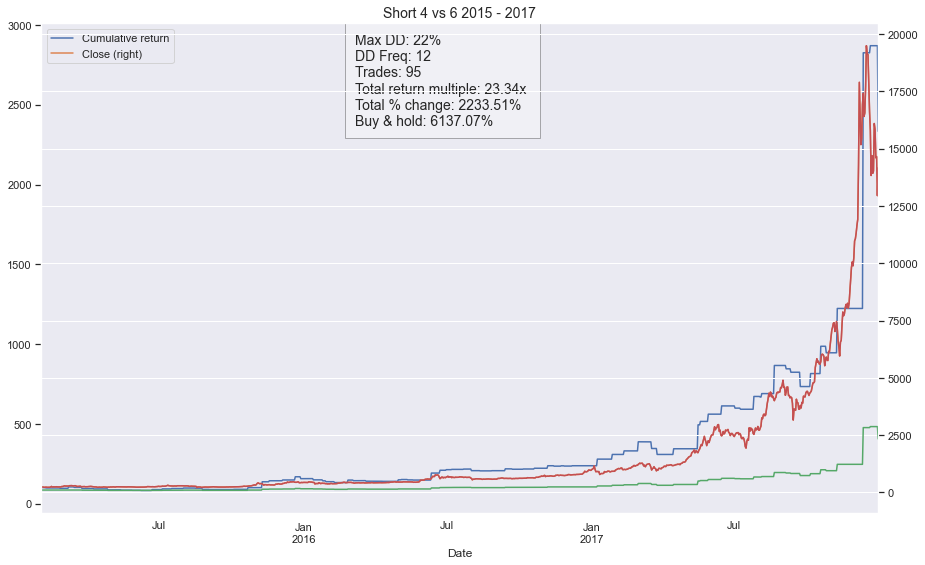

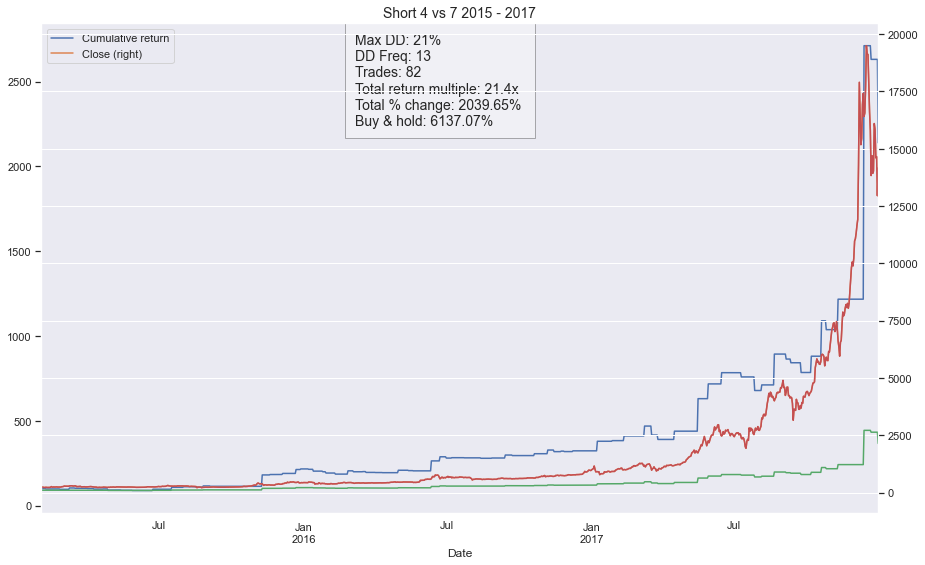

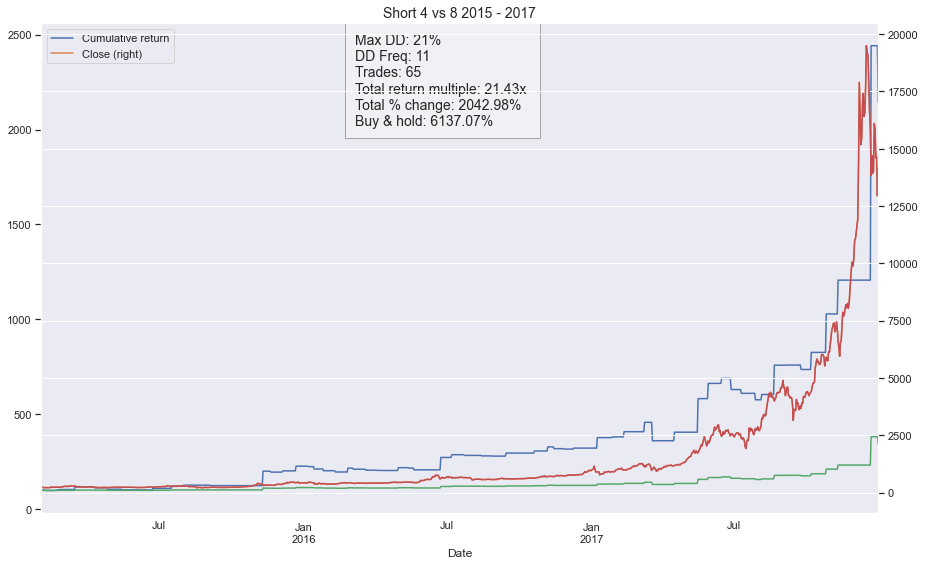

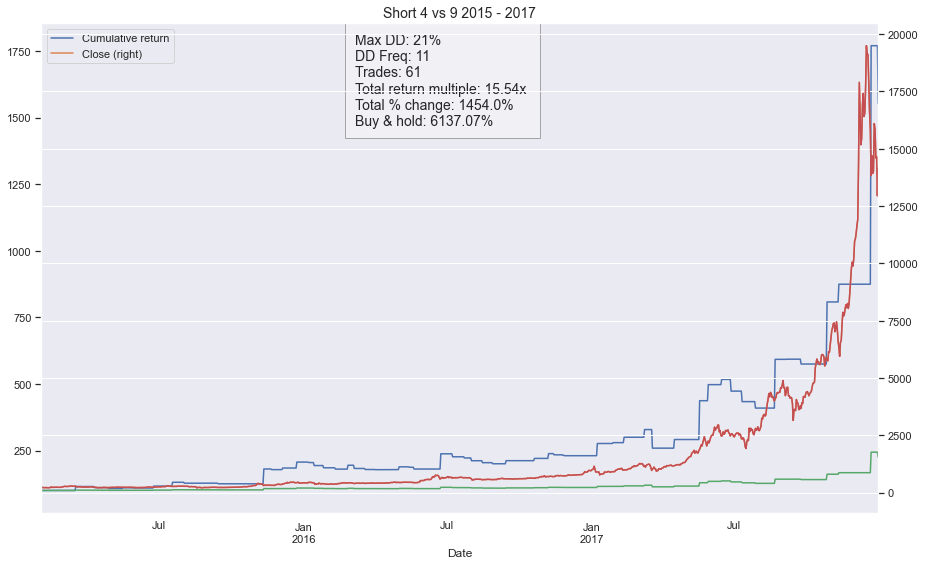

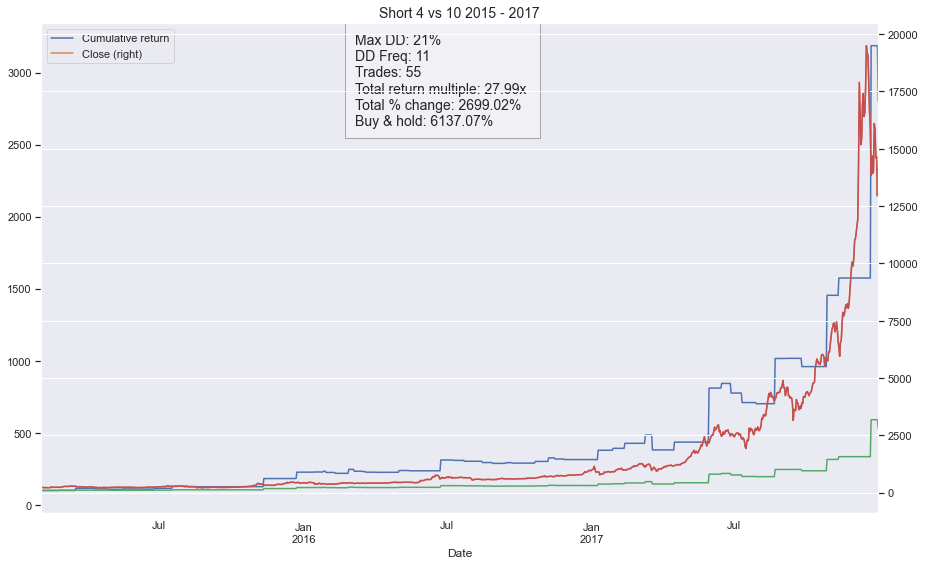

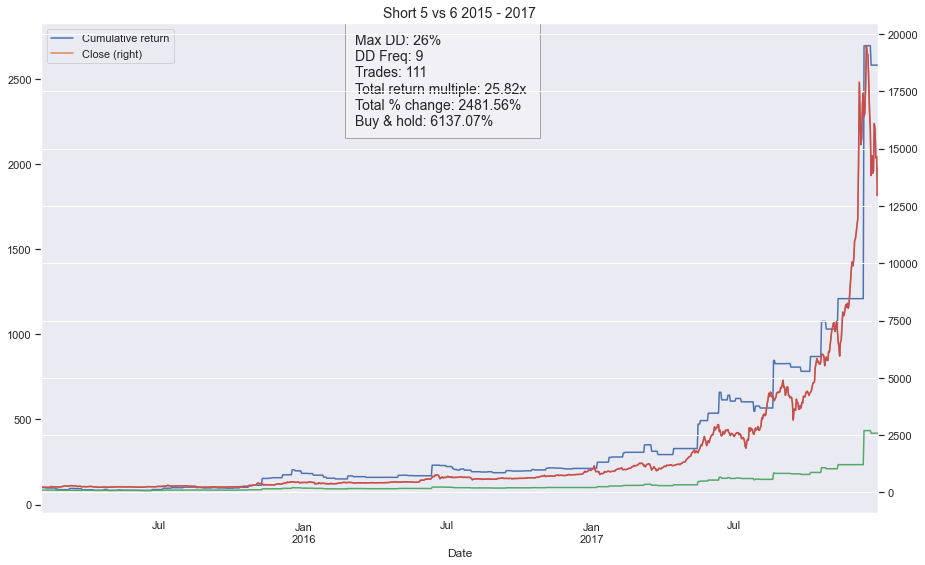

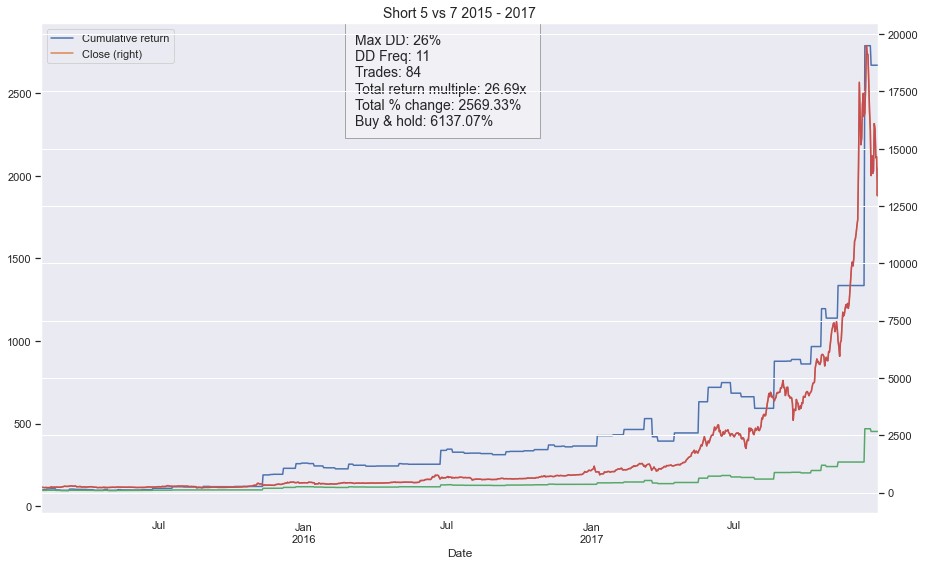

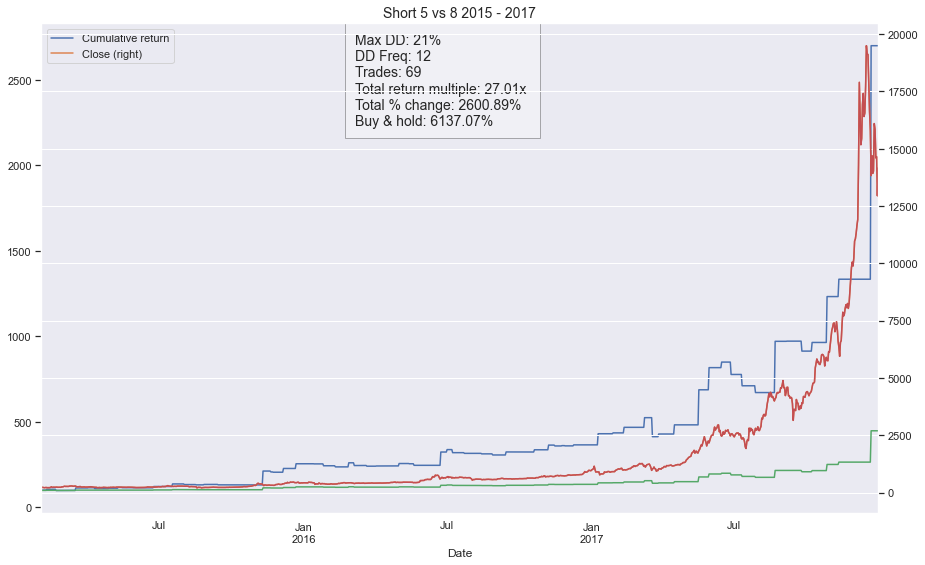

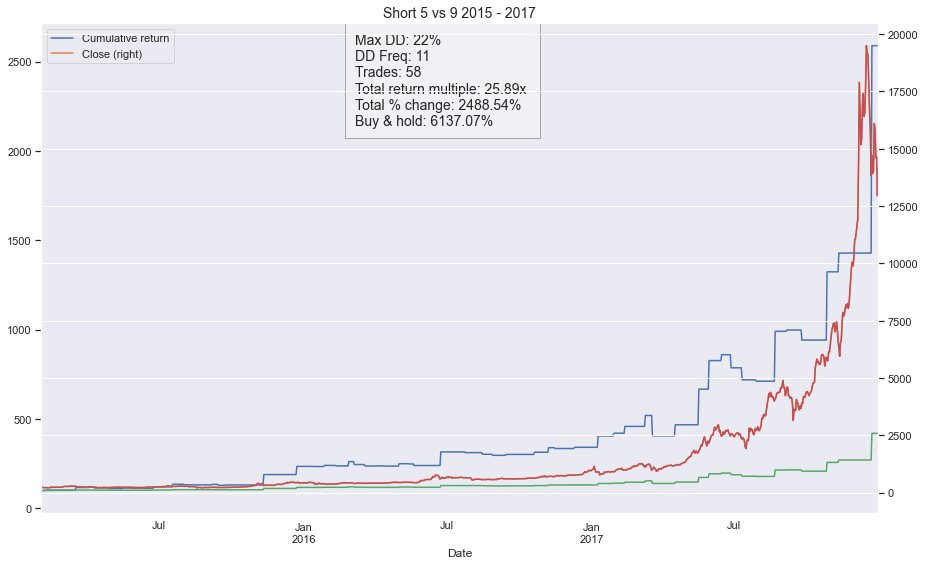

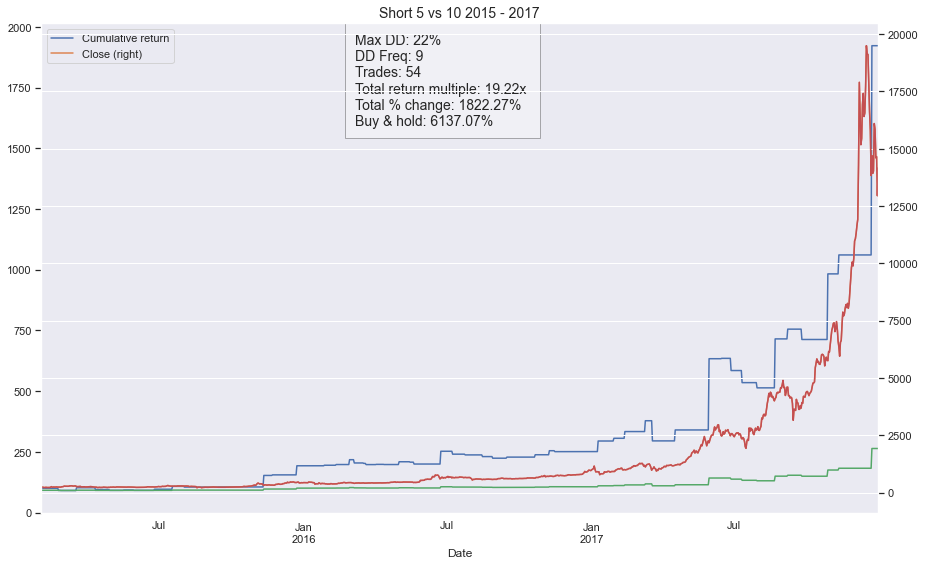

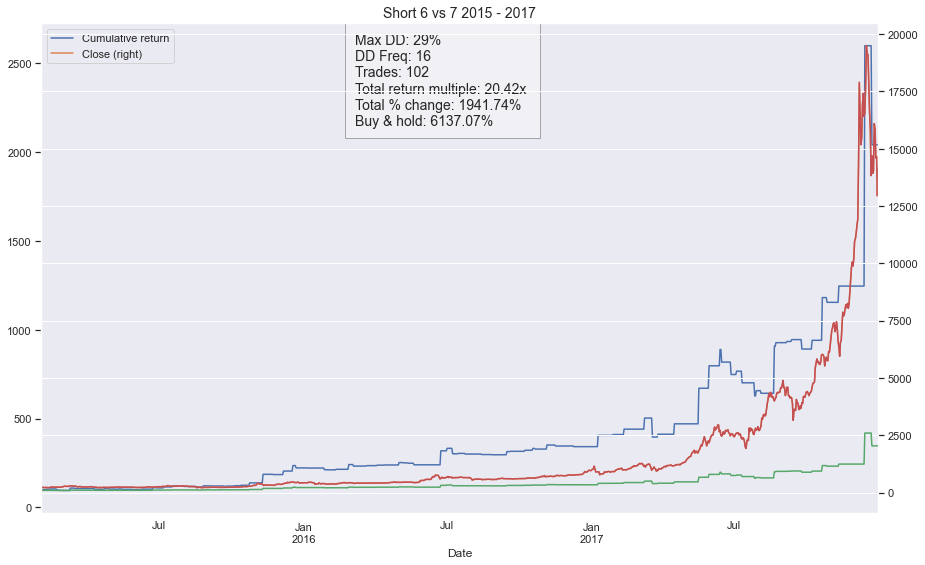

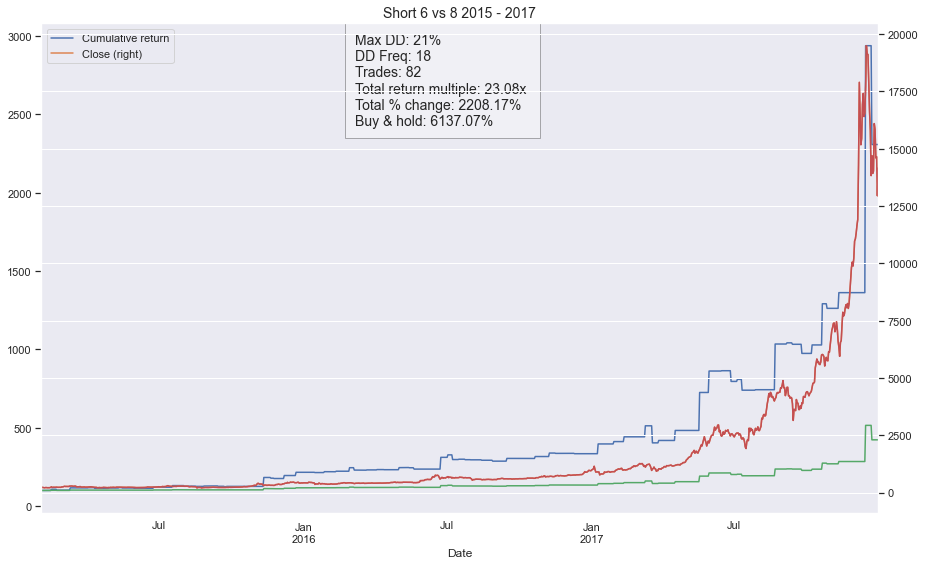

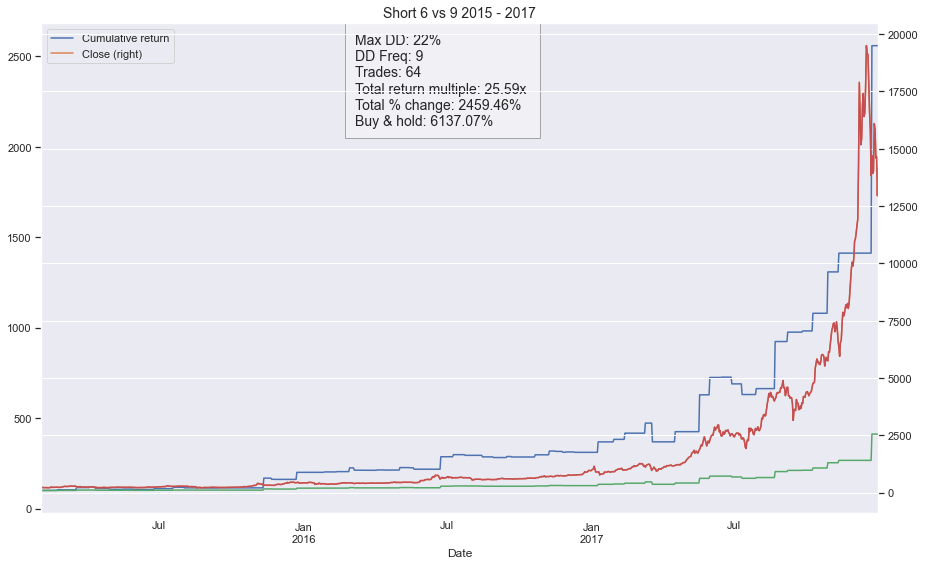

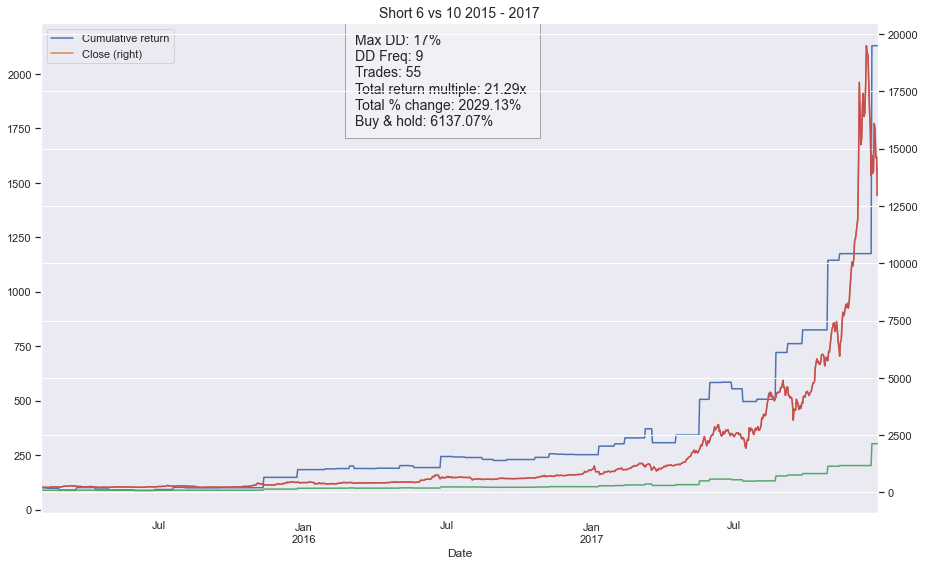

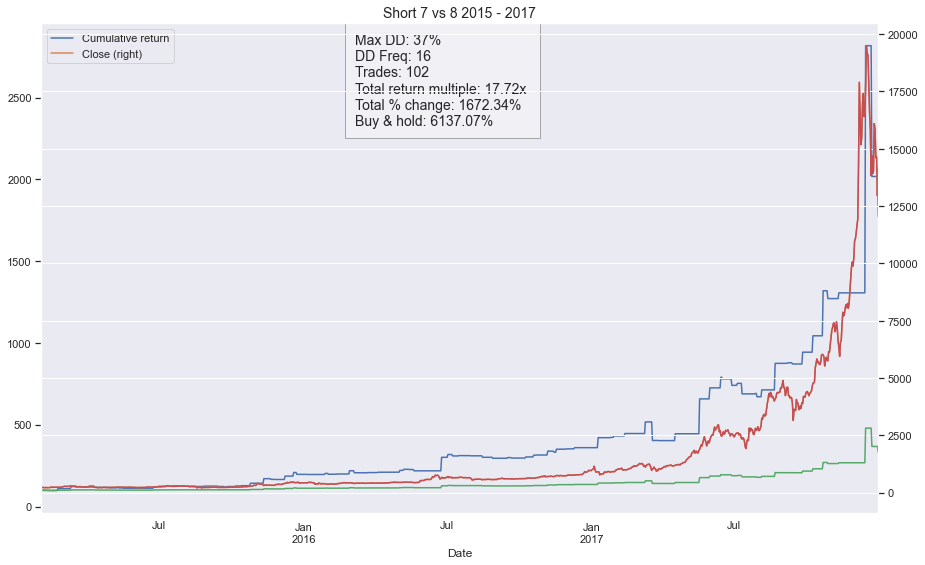

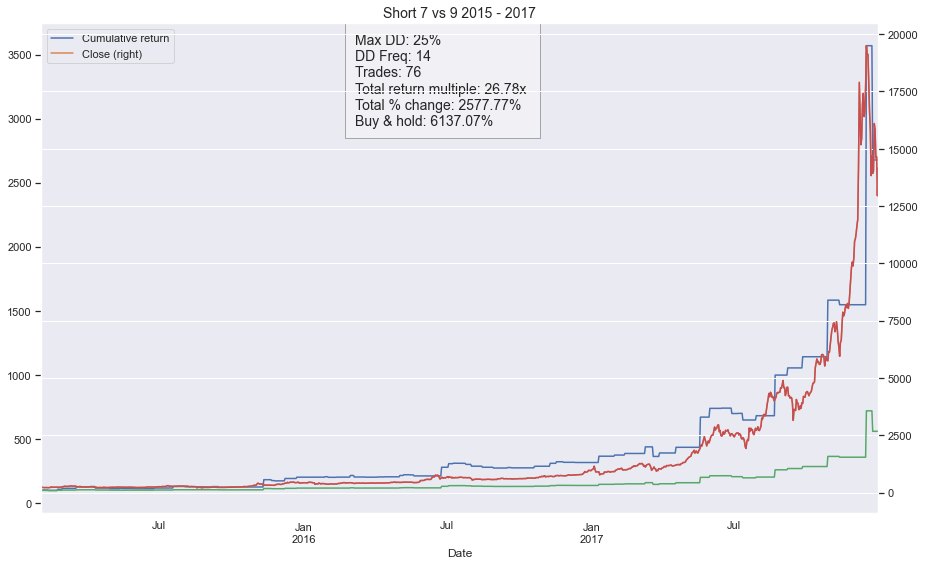

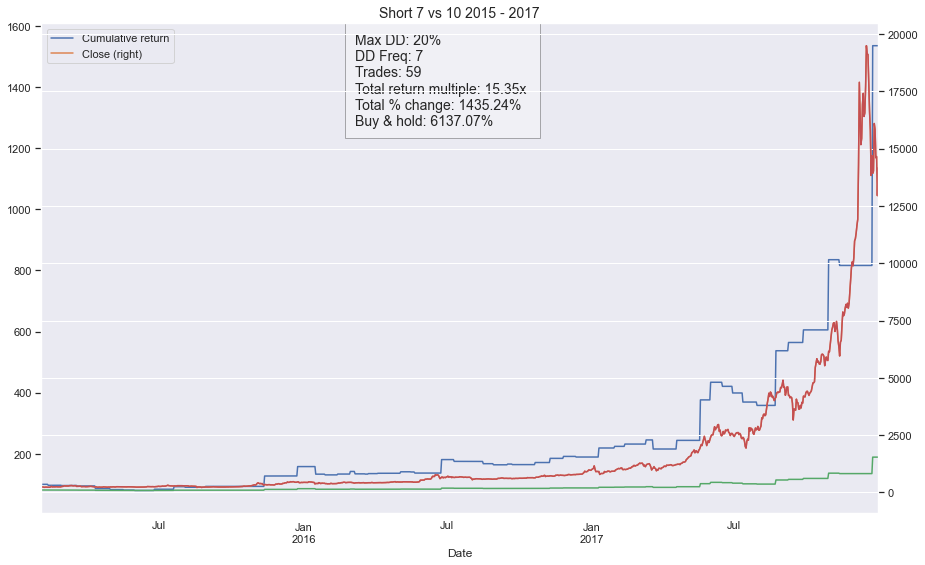

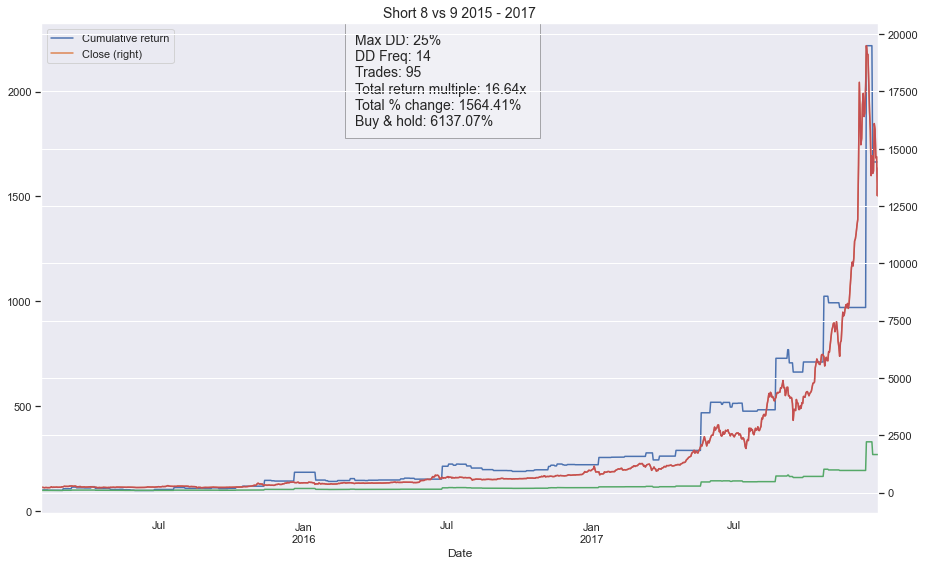

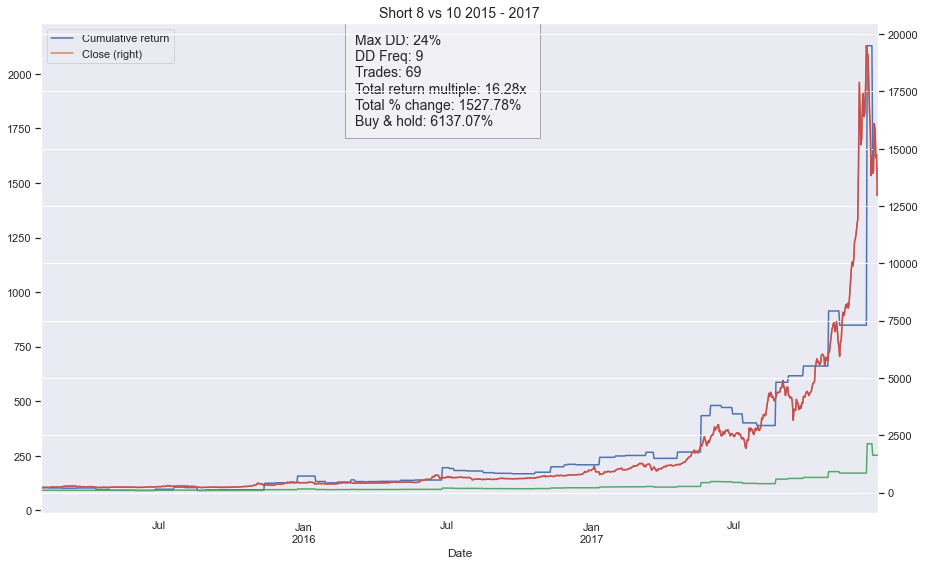

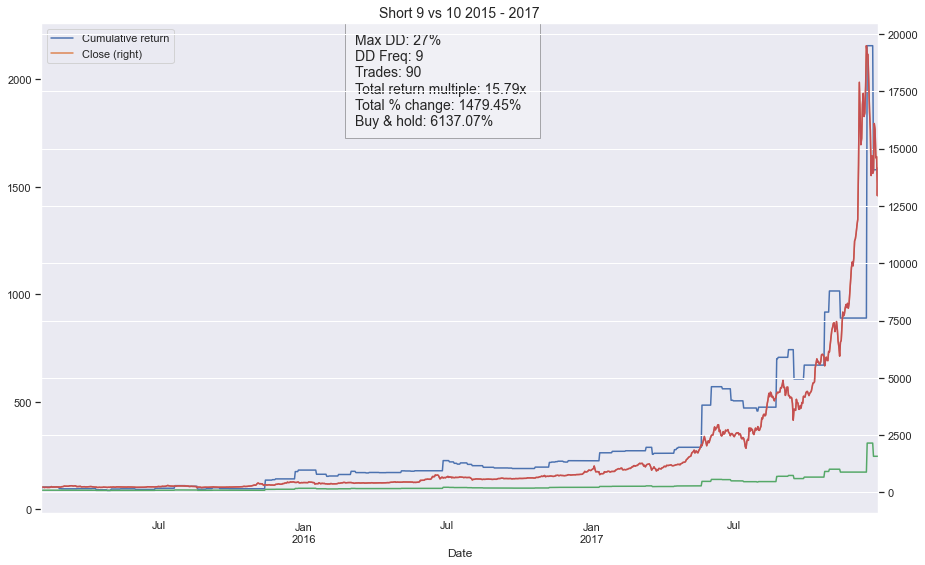

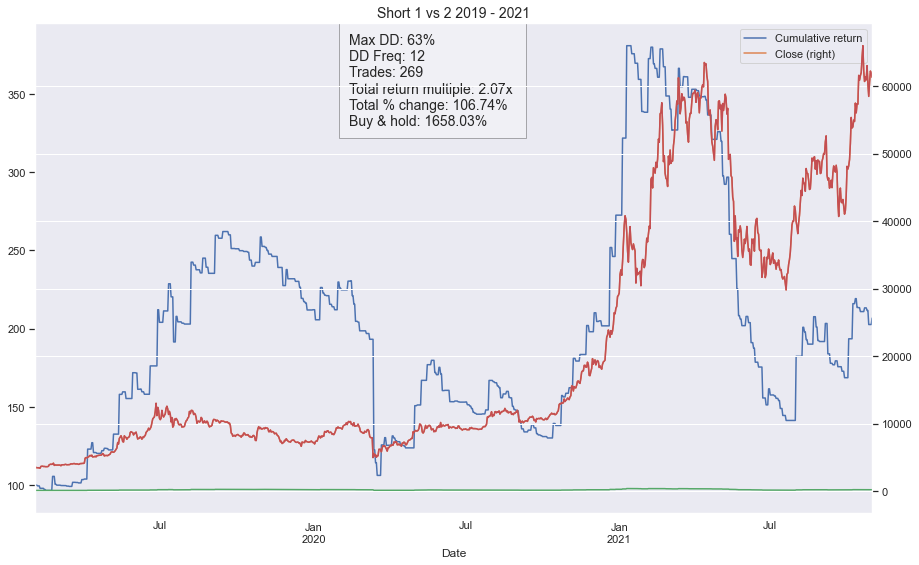

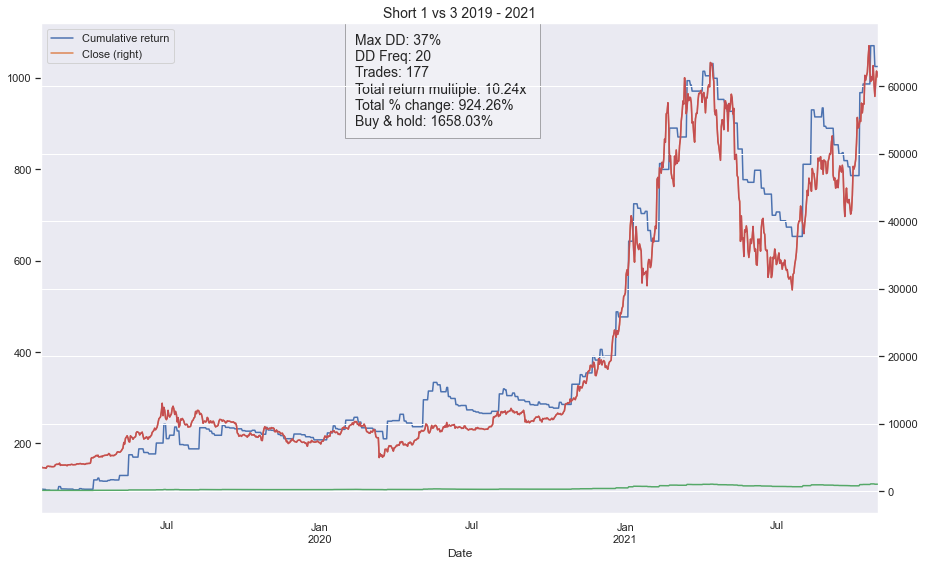

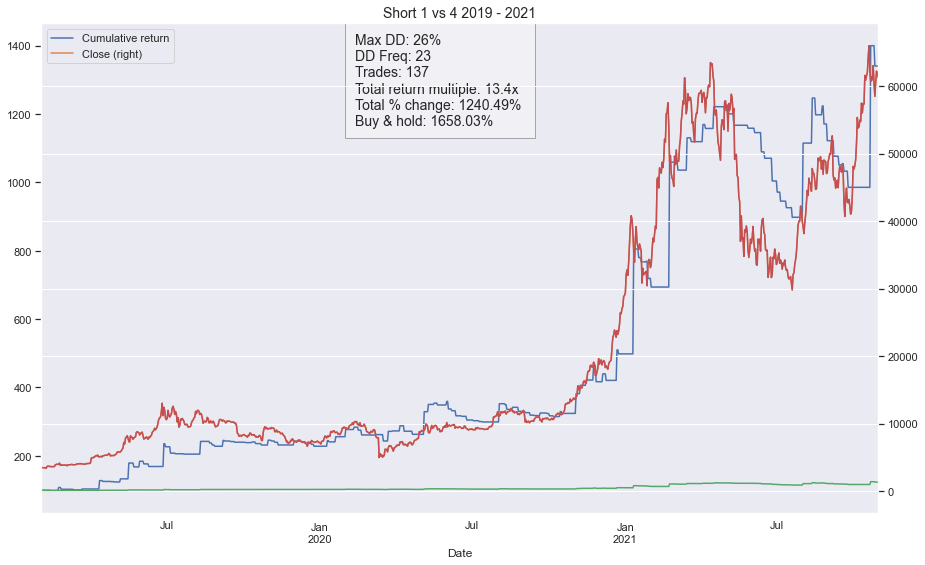

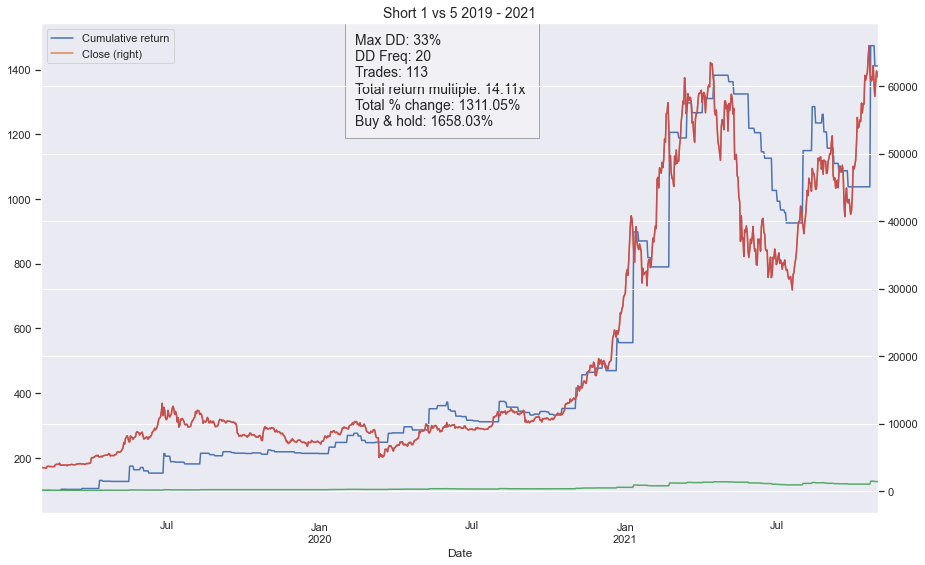

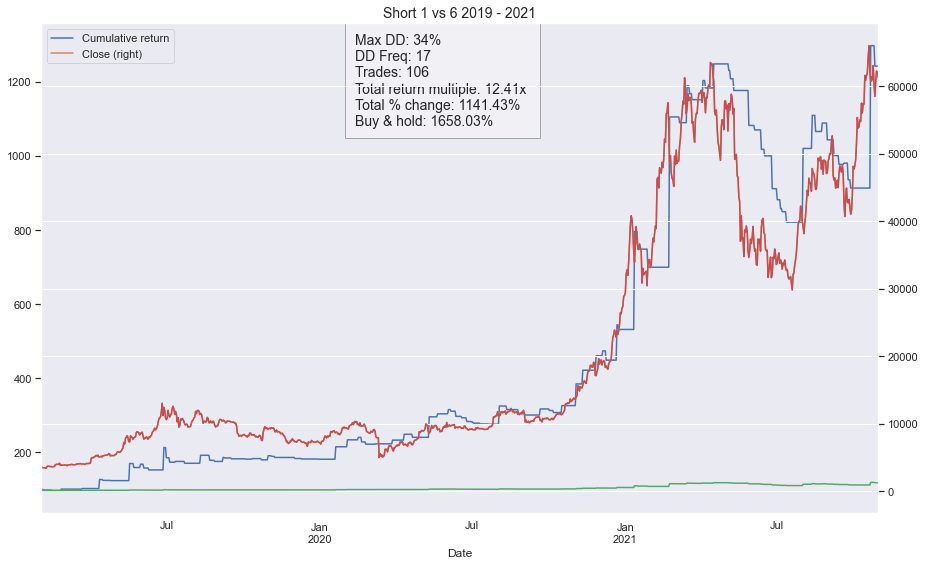

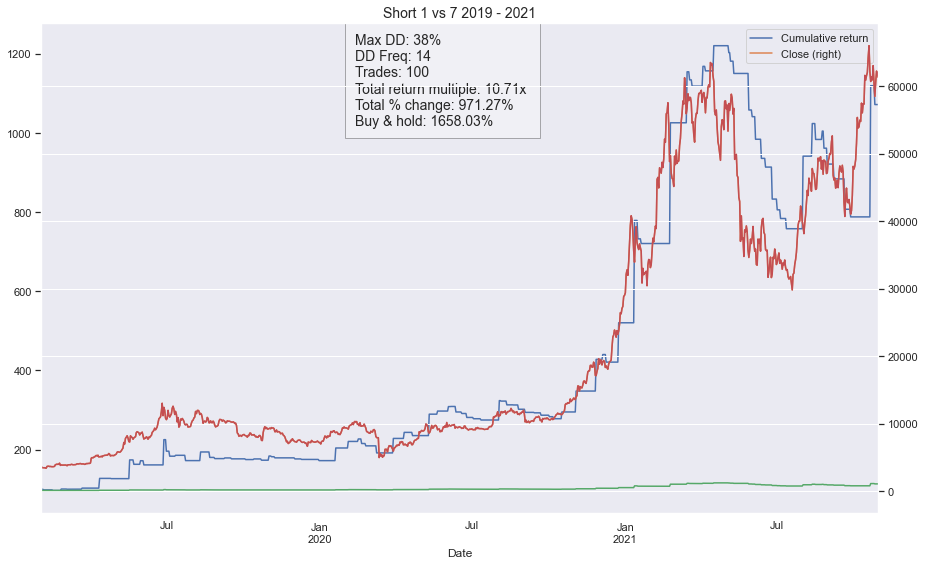

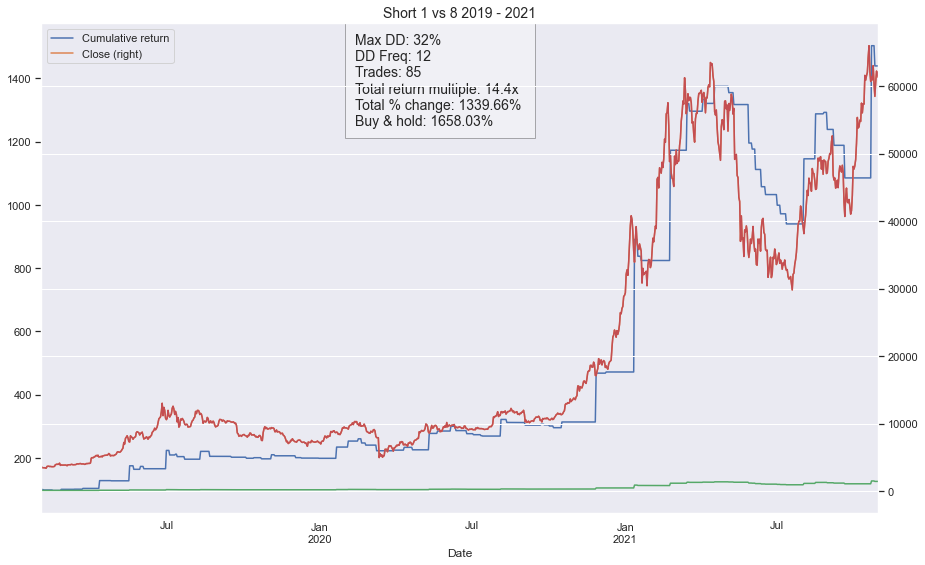

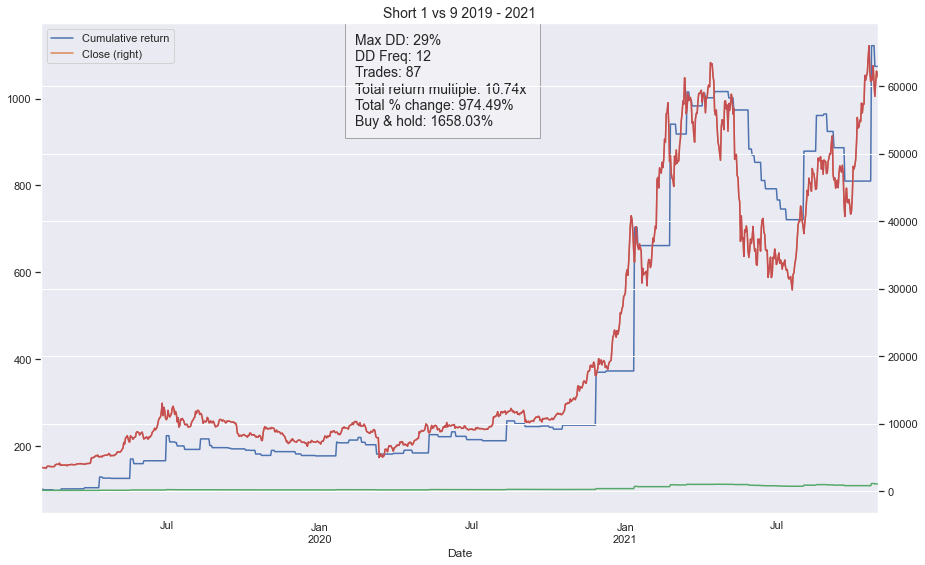

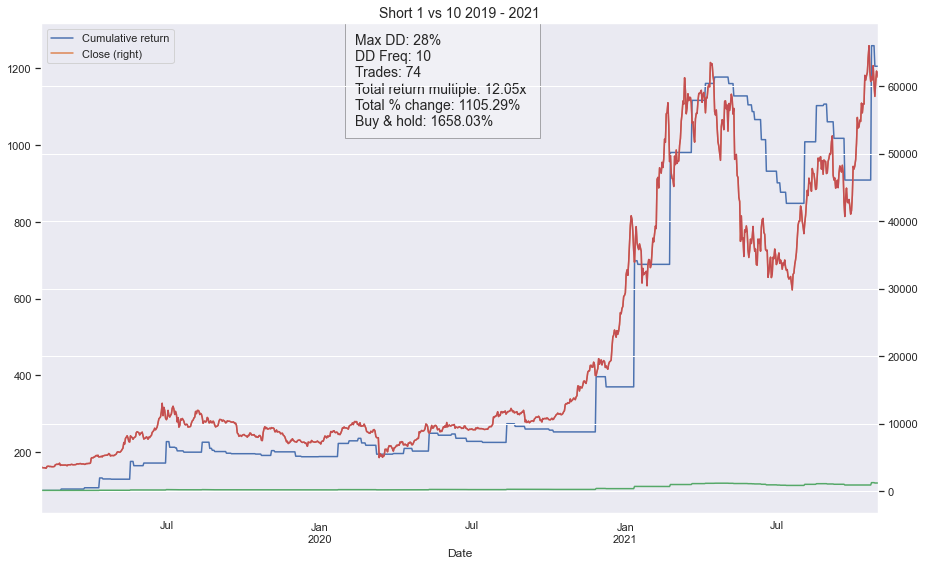

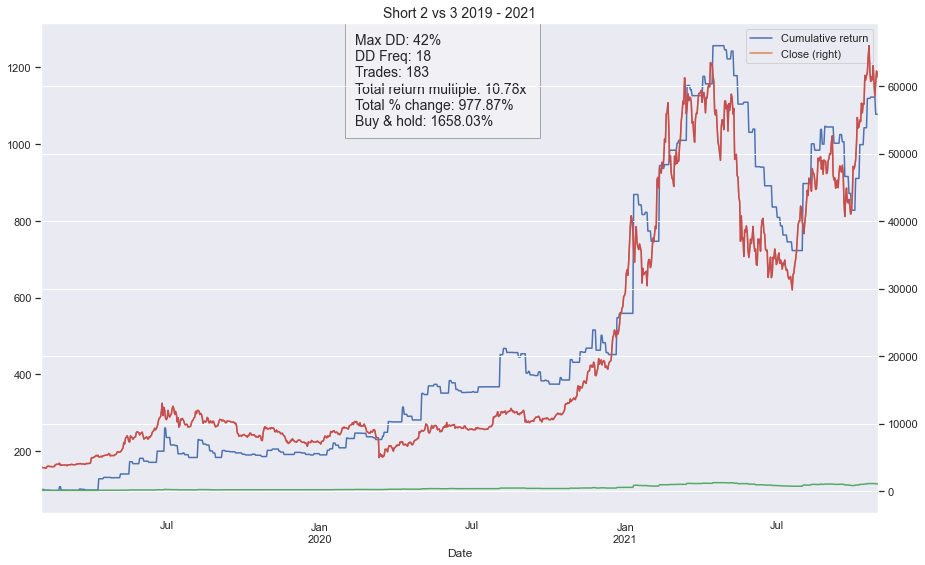

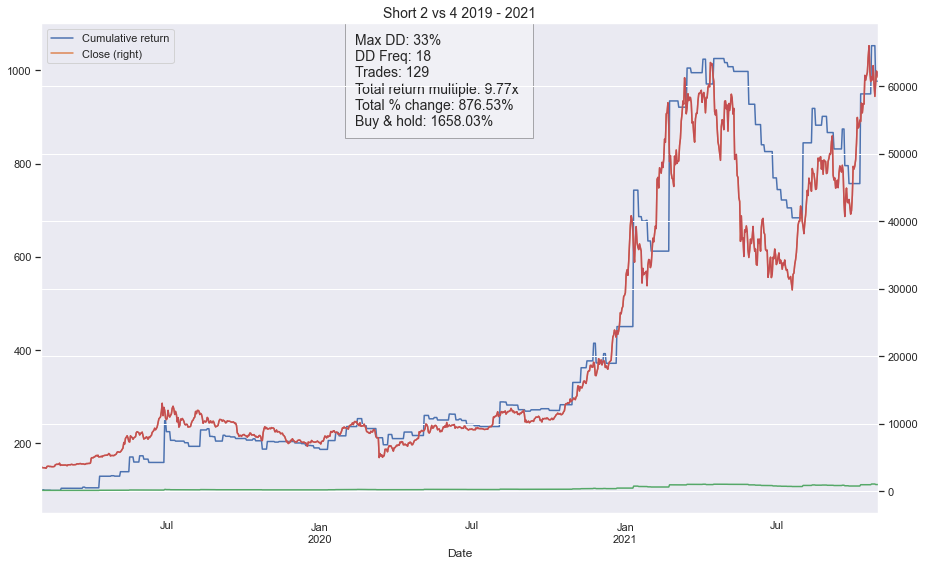

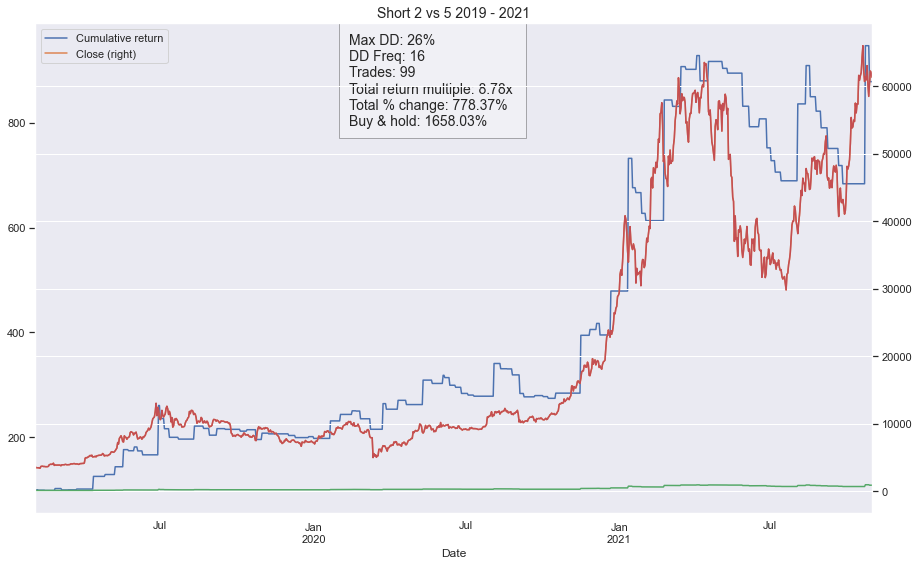

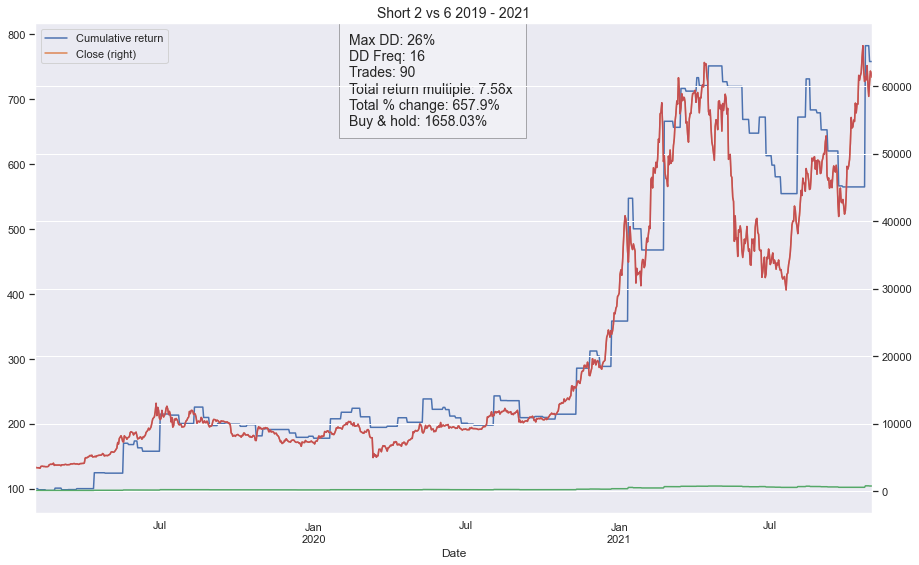

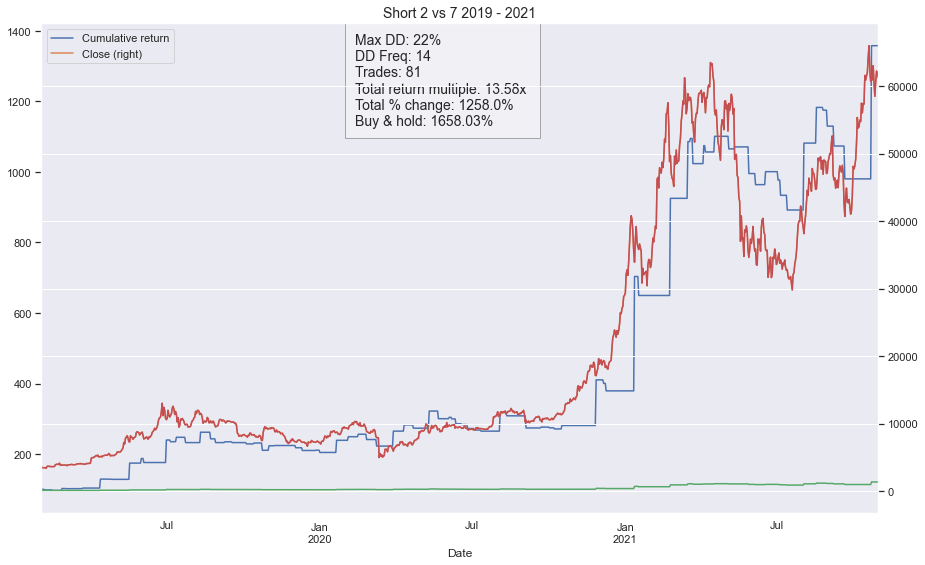

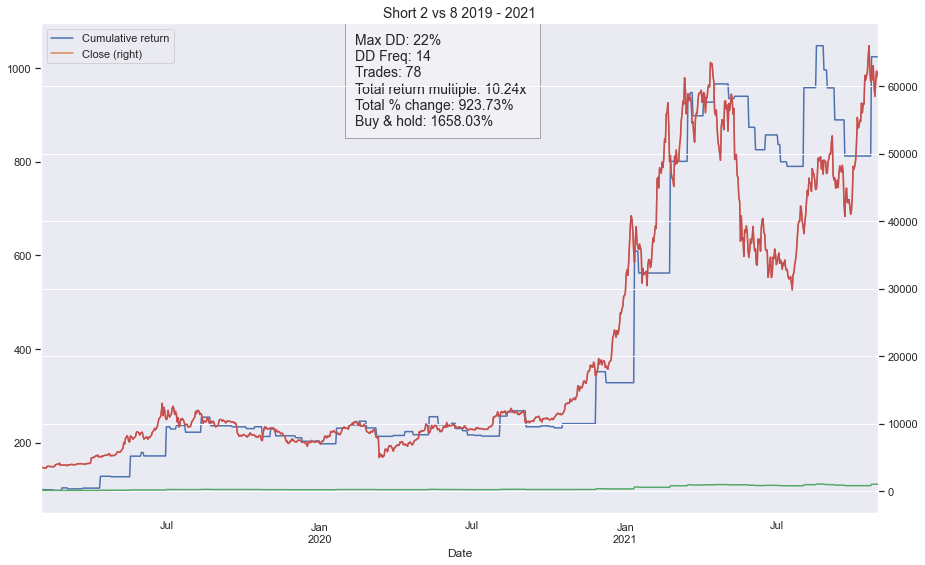

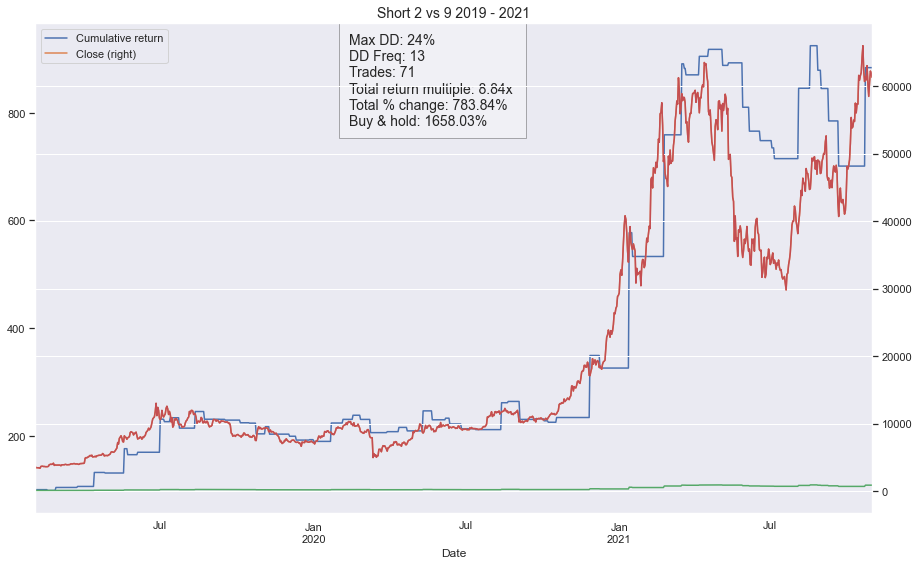

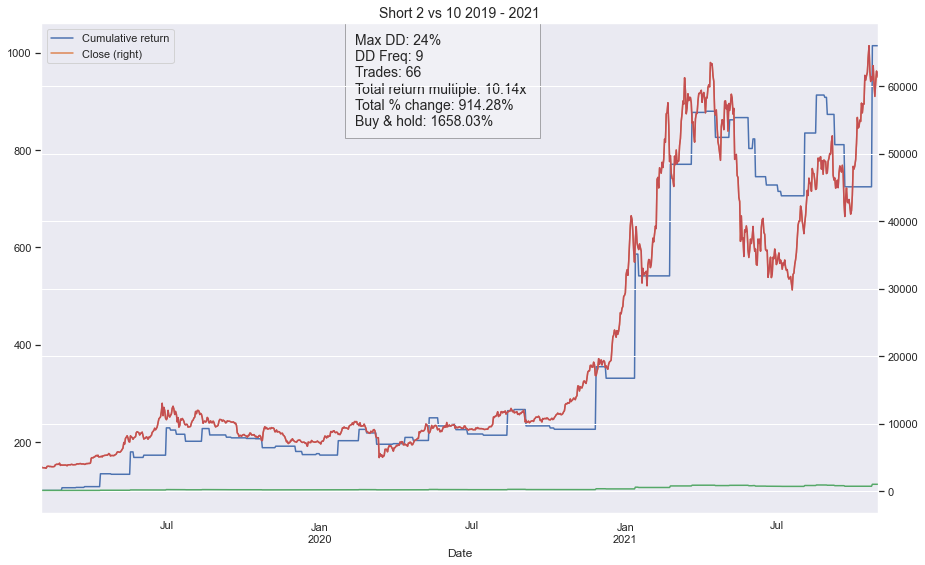

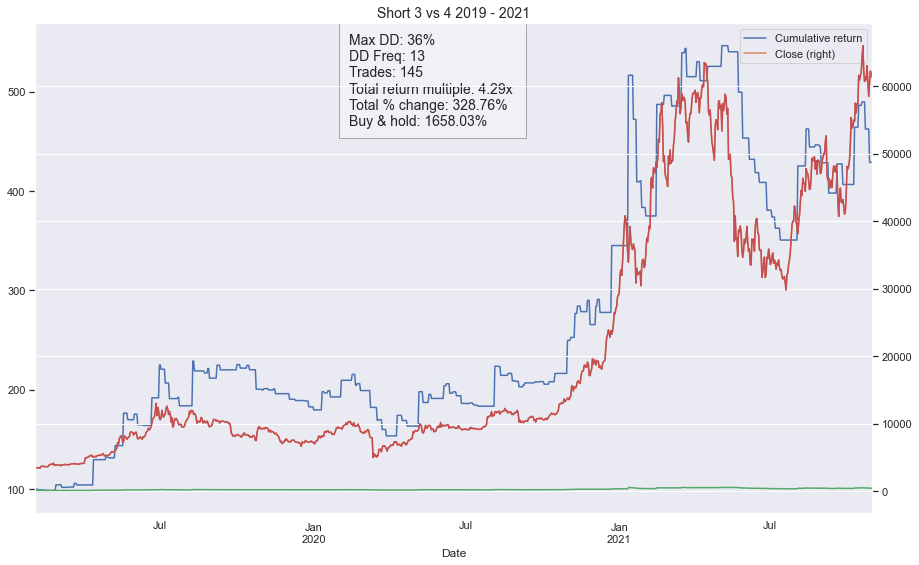

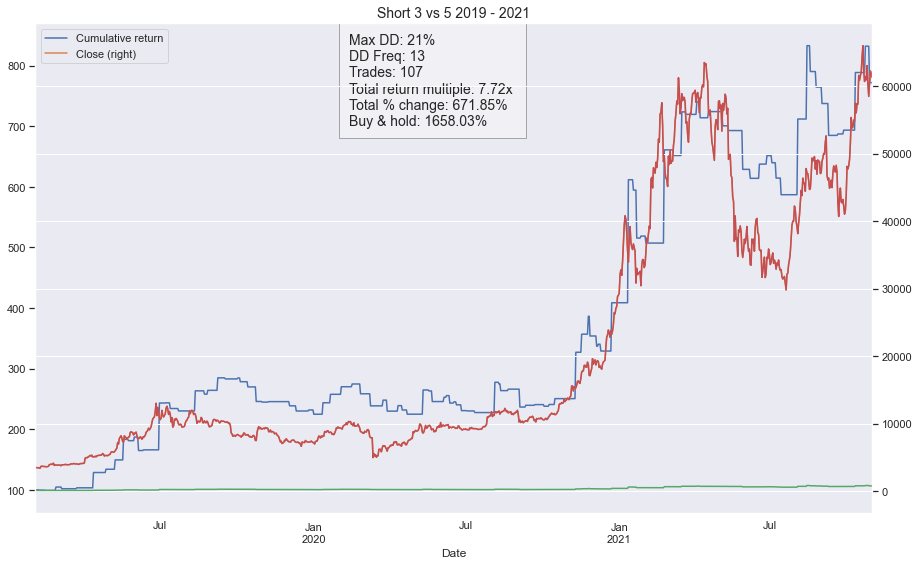

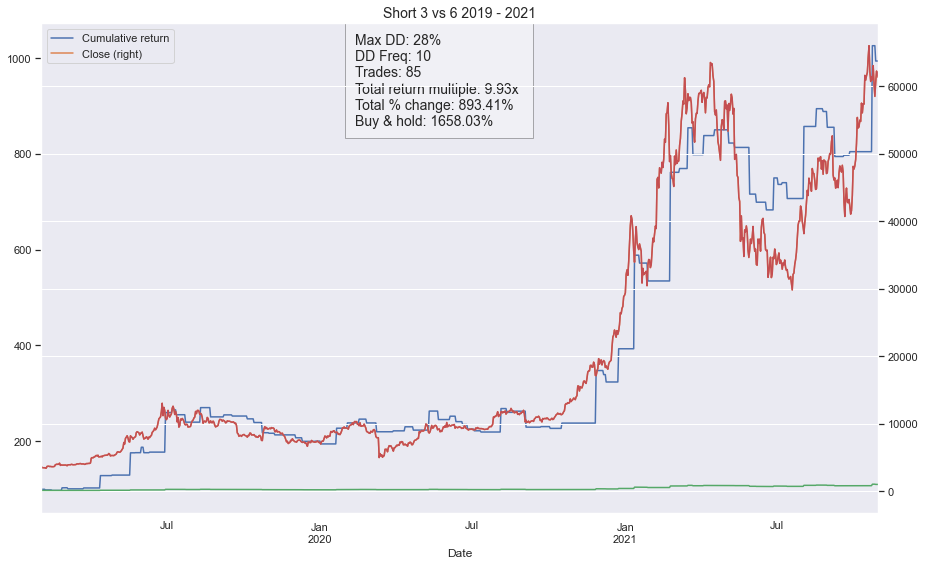

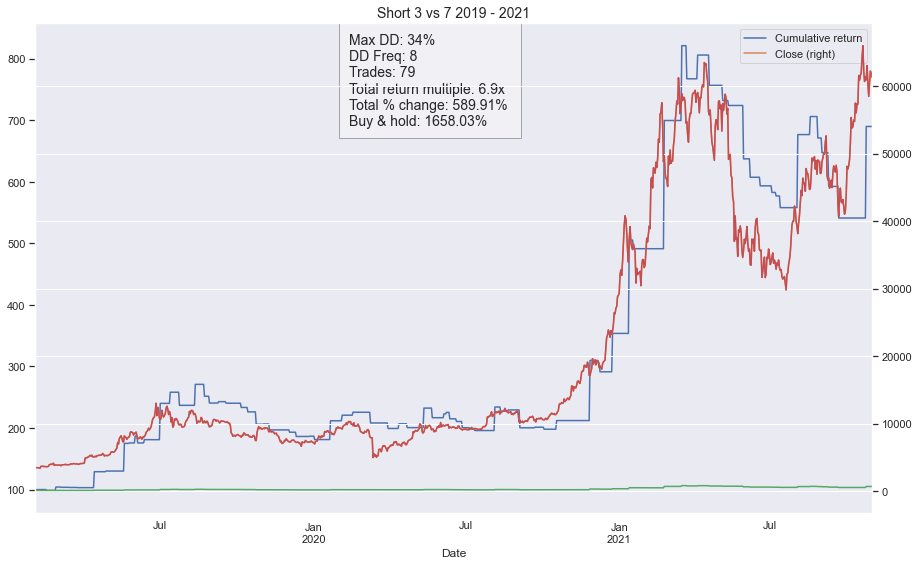

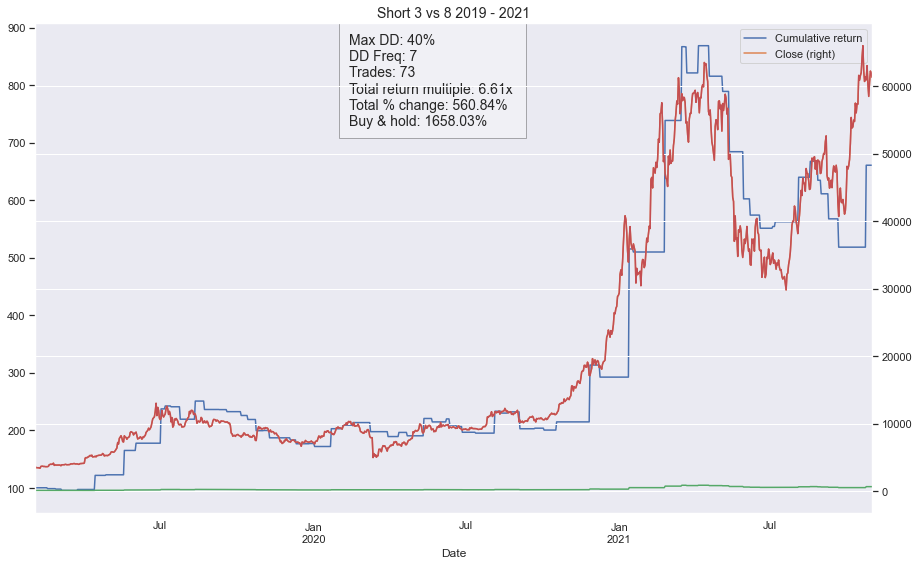

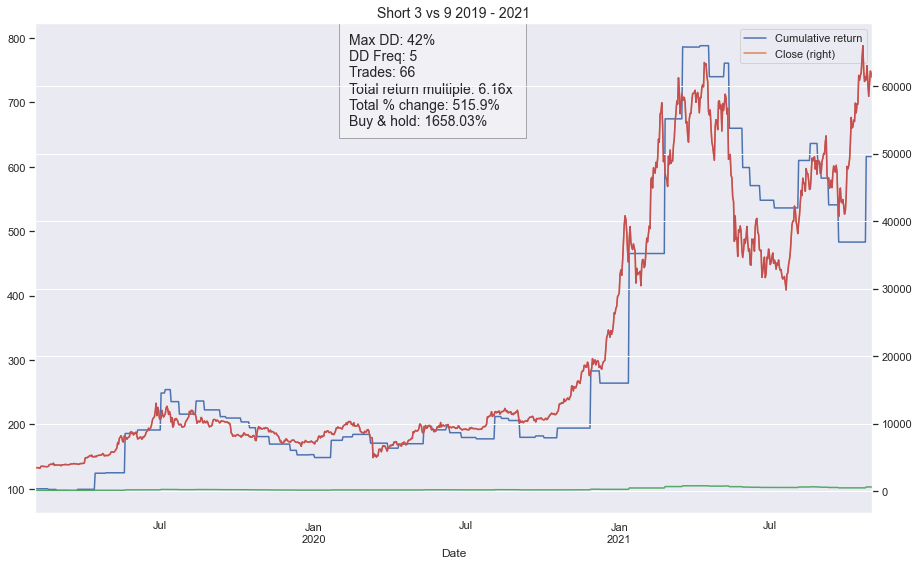

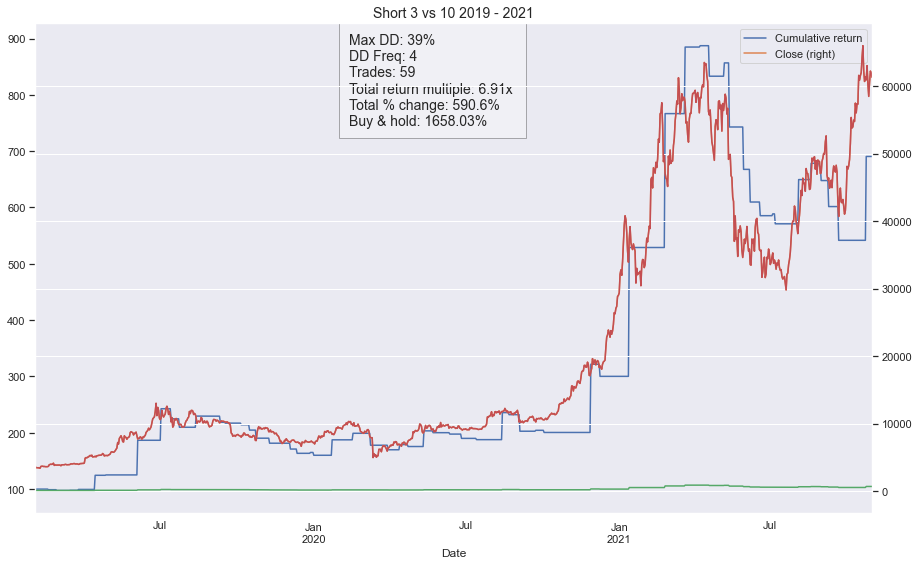

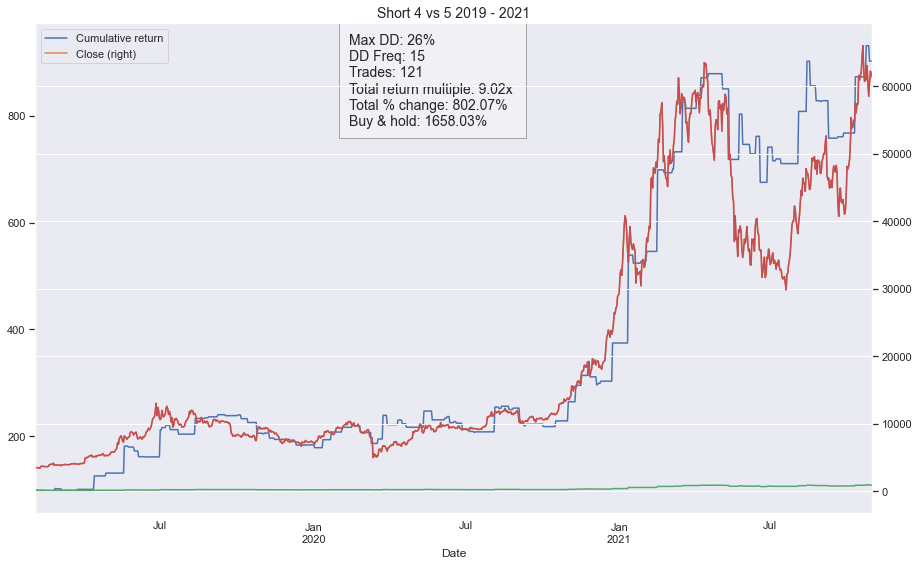

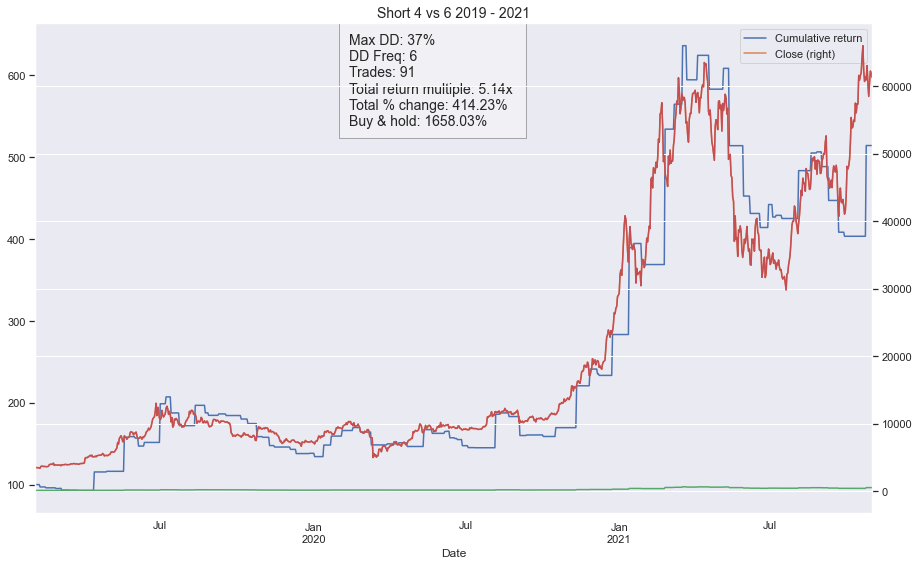

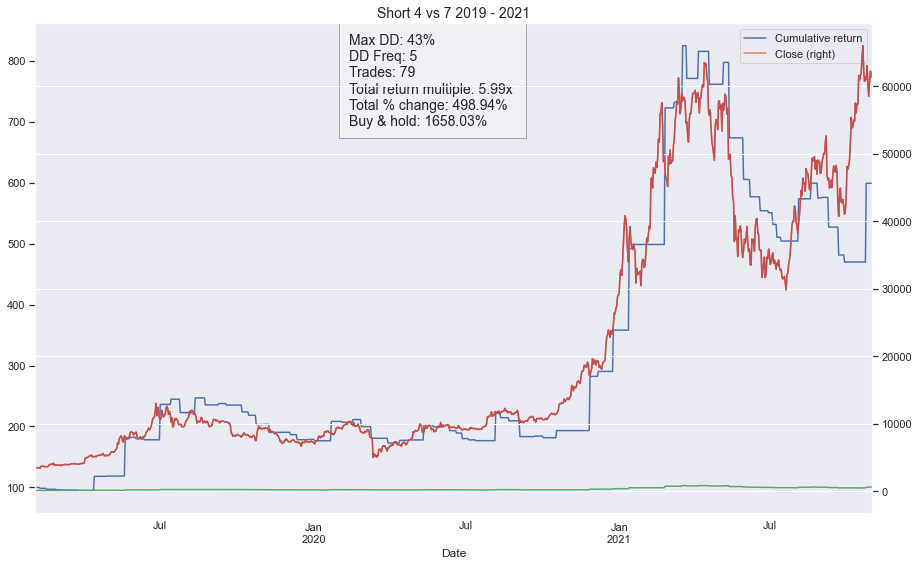

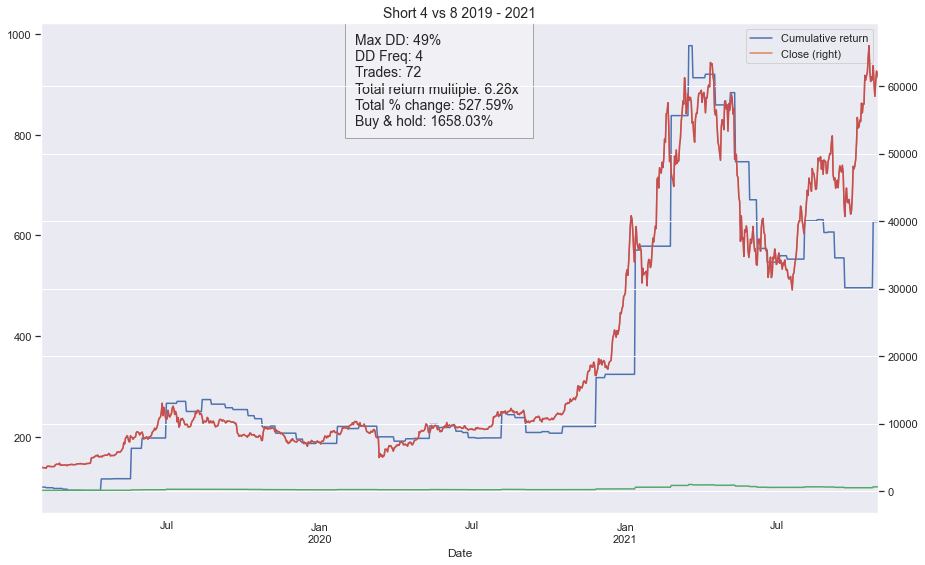

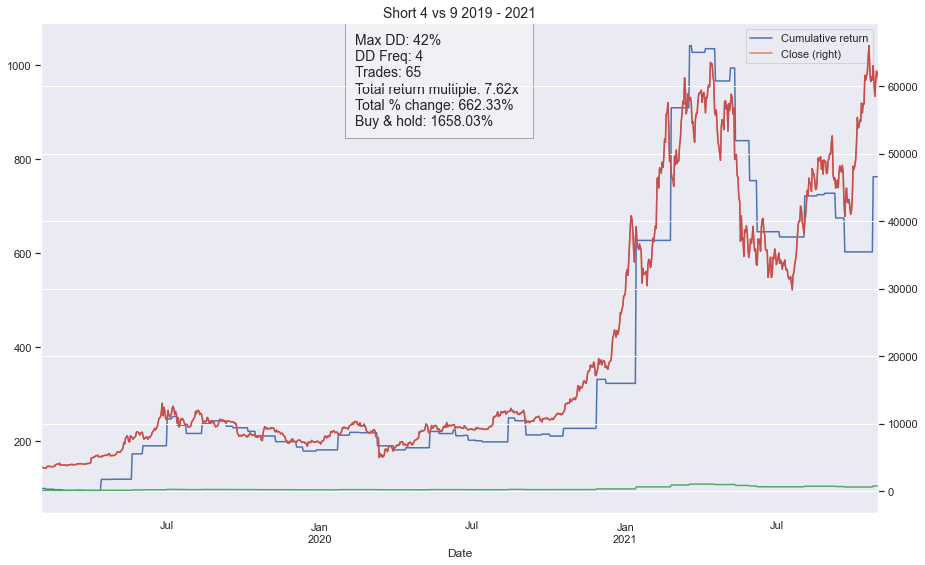

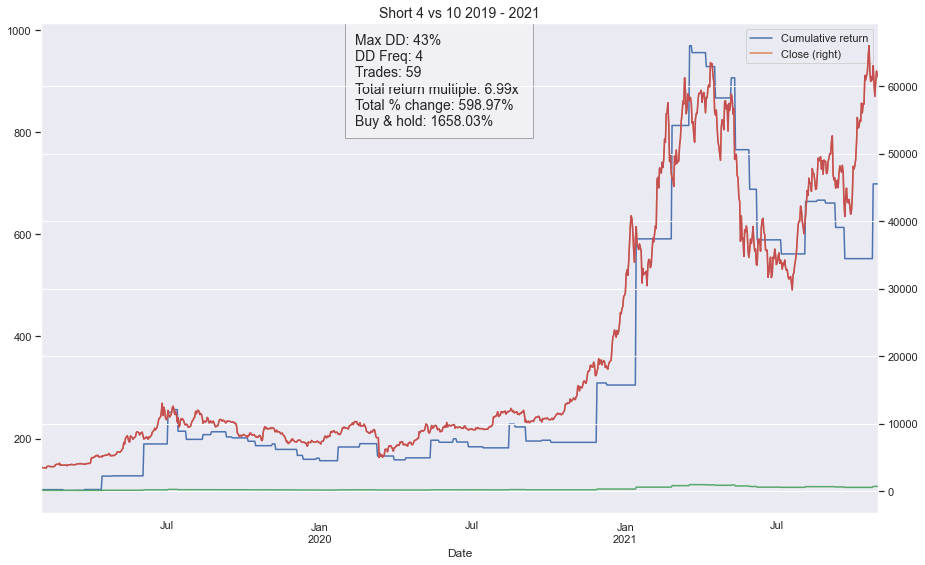

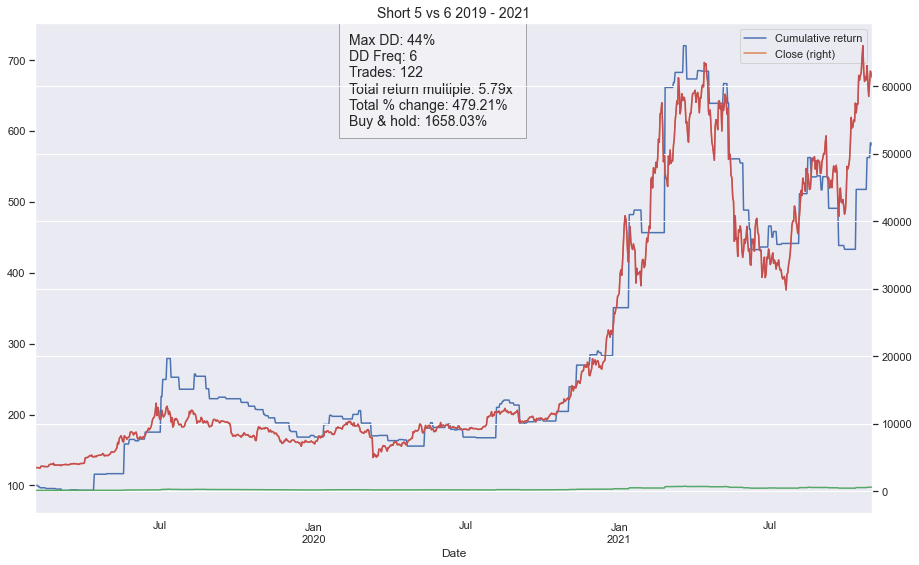

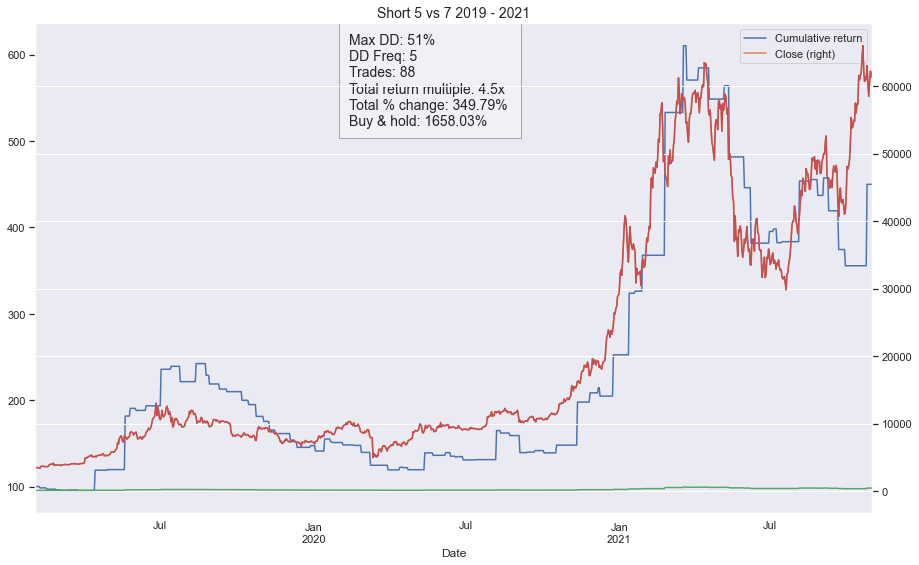

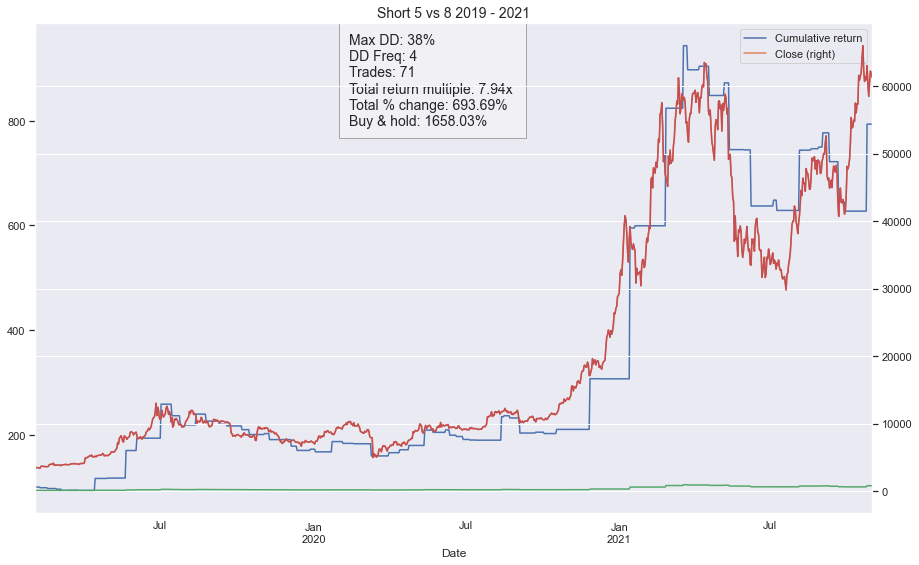

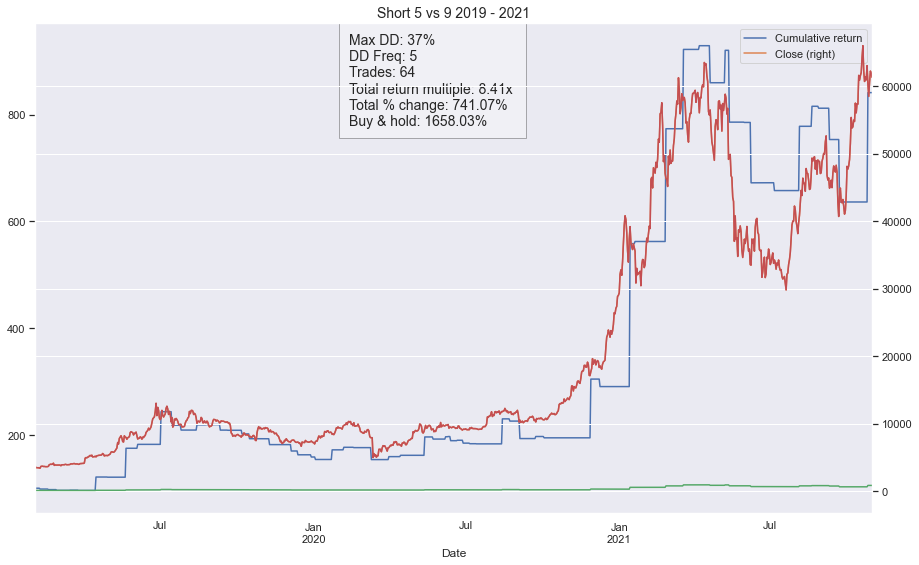

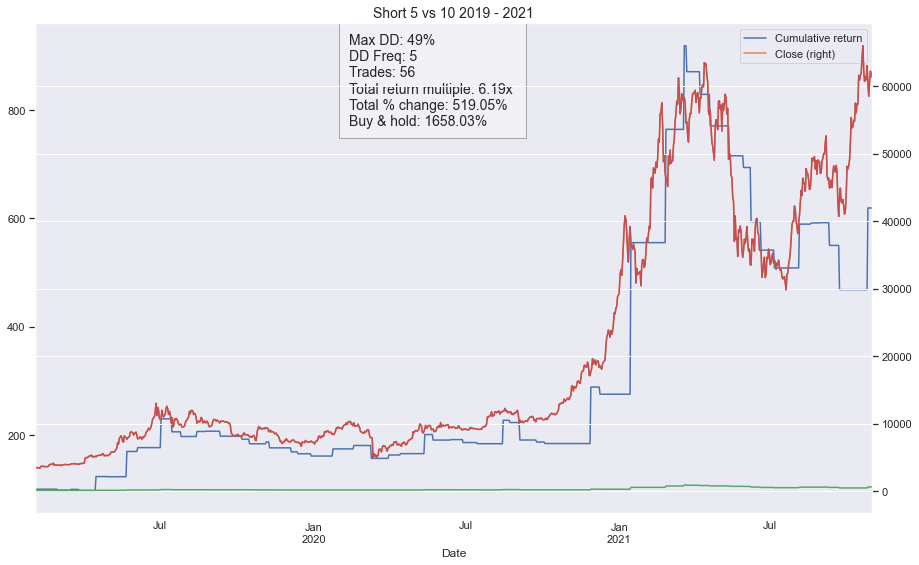

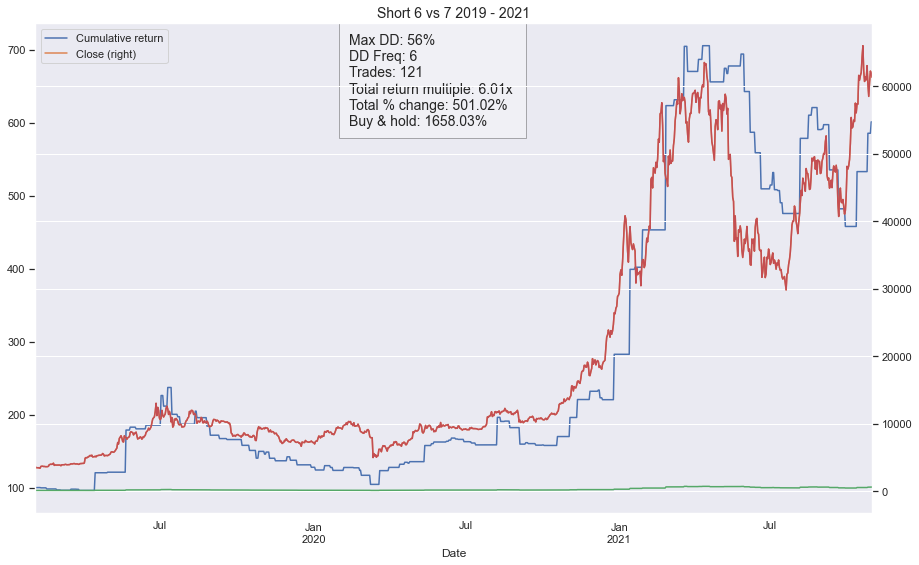

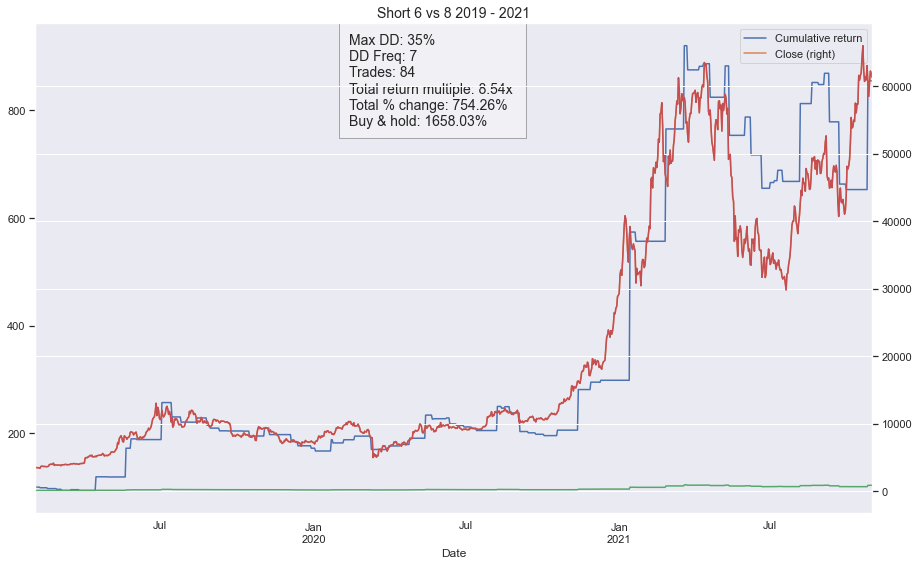

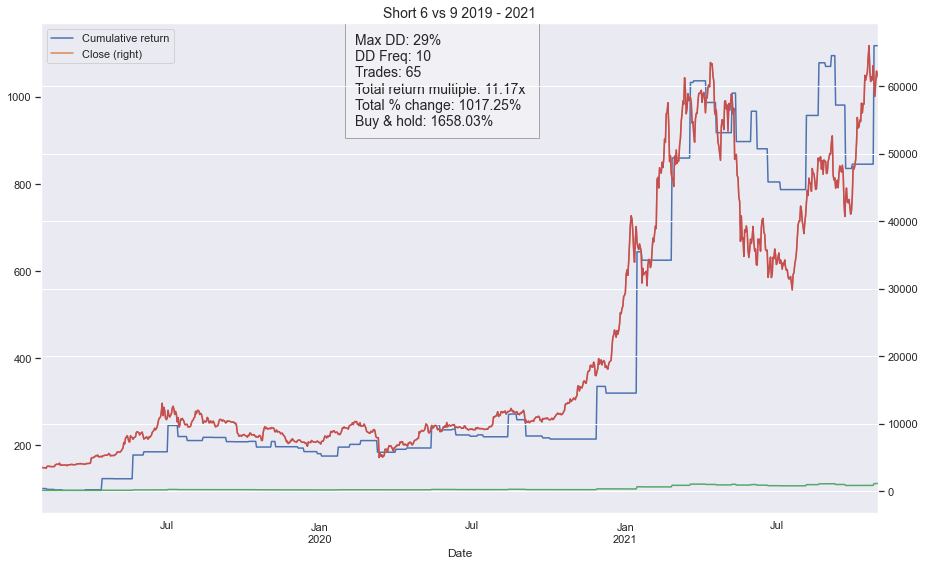

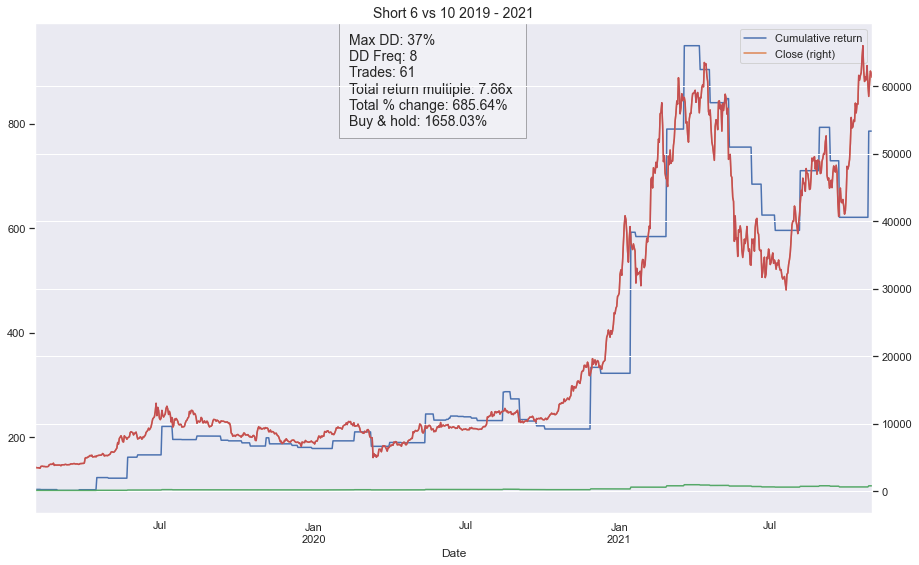

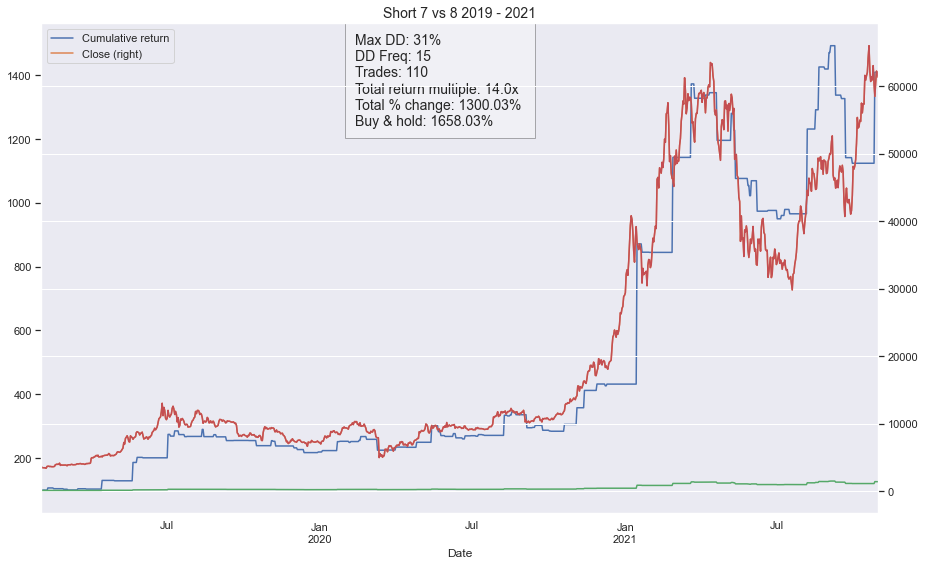

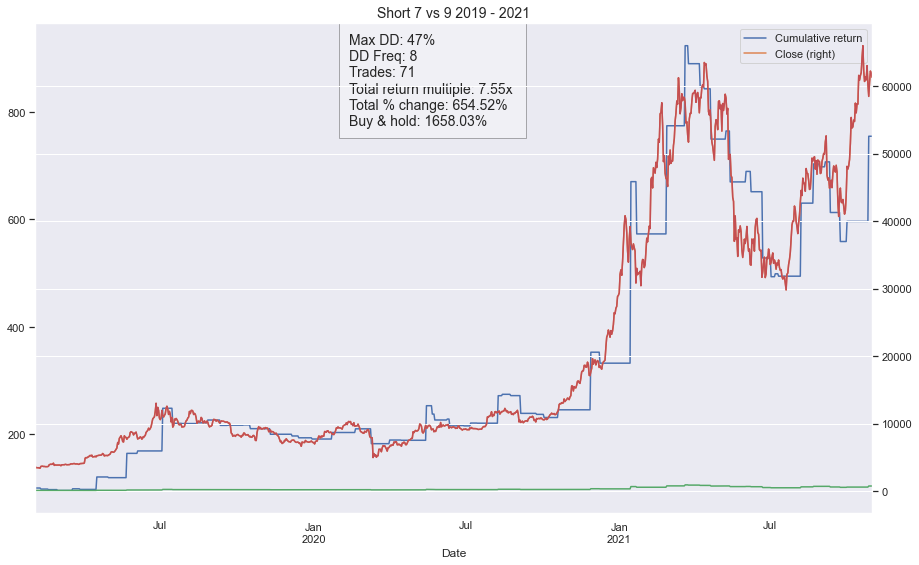

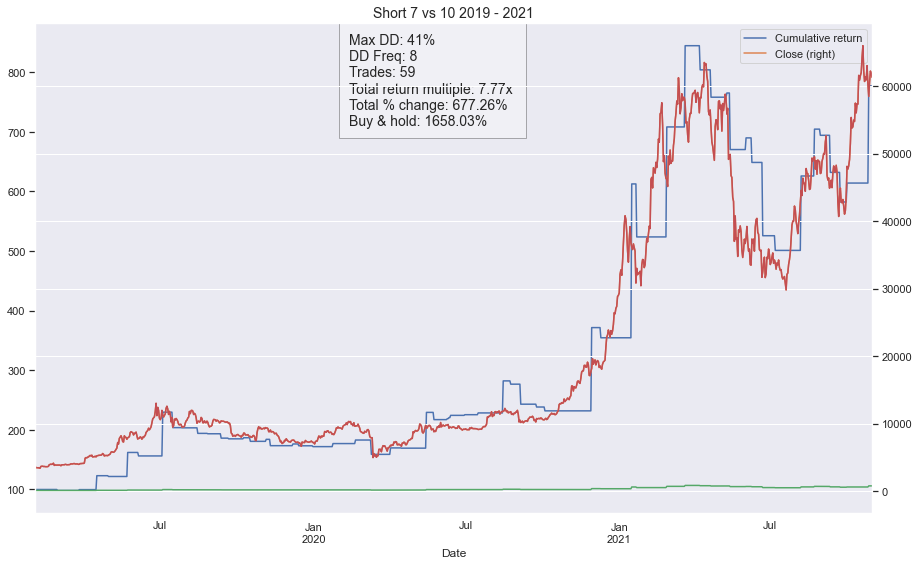

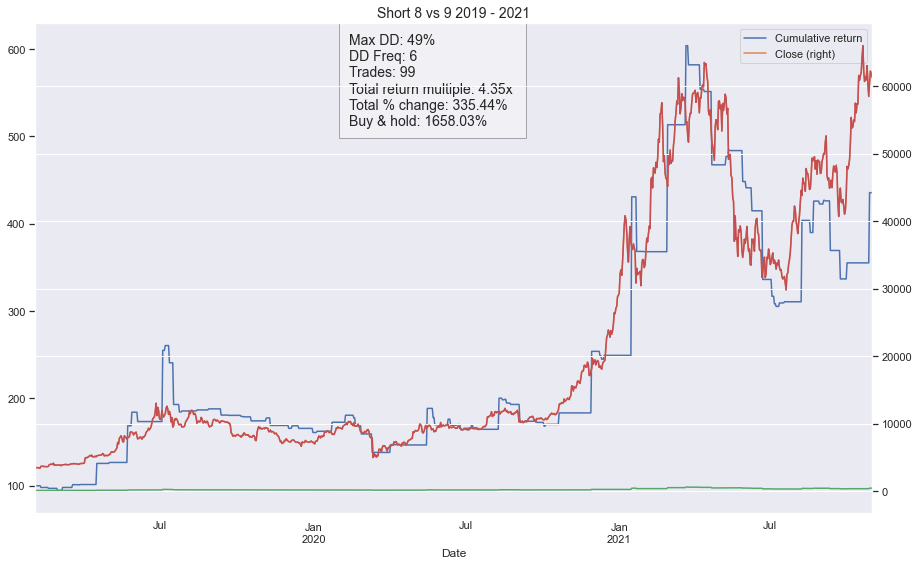

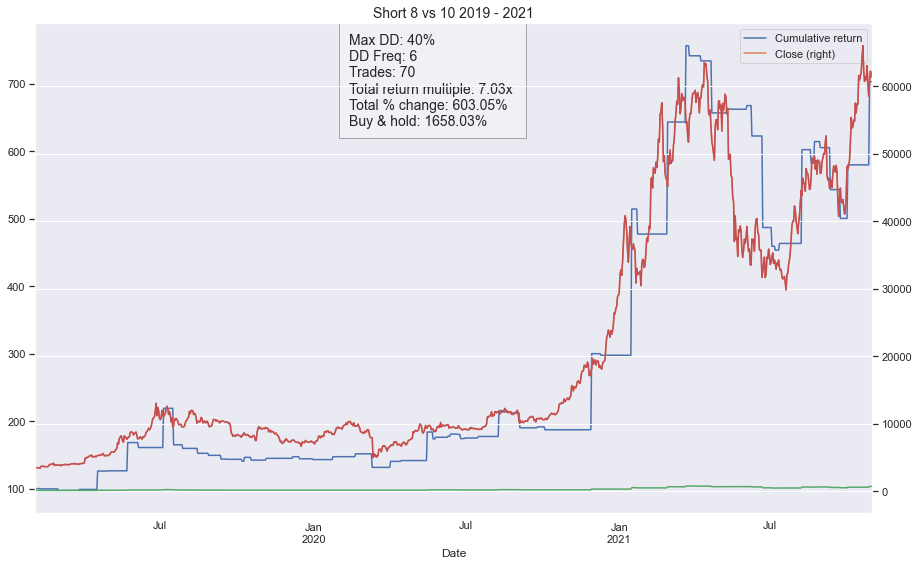

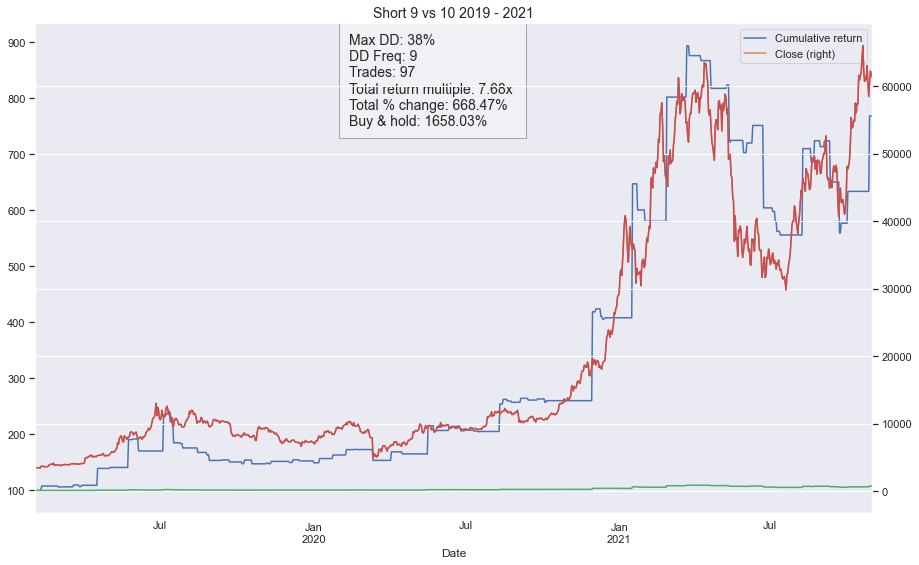

In [5]:
# For each test period
p = 0
for df in df_list:
    returns = []
    names = []
    long = False
    trade_count = 0
    position_tracker = []
    
    # For each sma pair
    for sma in pairs:
    
        # For each df record
        for i in range(1,len(df)):
            
            # Rarely, two smas can have equal values
            if df.iloc[i-1][f'sma_{sma[0]}'] == df.iloc[i-1][f'sma_{sma[1]}']:
                returns.append(0)
                position_tracker.append(np.nan)
                #names.append(df.iloc[i].name)
            
            # Bull cross
            if df.iloc[i-1][f'sma_{sma[0]}'] > df.iloc[i-1][f'sma_{sma[1]}']:
                if long == True: # pad returns
                    returns.append(0)
                    position_tracker.append(np.nan)
                    #names.append(df.iloc[i].name)
                if long == False: # open short
                    l_open = df.iloc[i]['Open']
                    position_tracker.append(1) # documents open of long
                    long = True
                    returns.append(0)
                    #names.append(df.iloc[i].name)
                
            # Bear Cross            
            if df.iloc[i-1][f'sma_{sma[0]}'] < df.iloc[i-1][f'sma_{sma[1]}']:
                if long == False:
                    returns.append(0)
                    position_tracker.append(np.nan)
                    #names.append(df.iloc[i].name)
                if long == True: # close short
                    l_close = df.iloc[i]['Open']
                    returns.append((l_close/l_open) - 1)
                    position_tracker.append(2) # documents close of long
                    trade_count += 1
                    long = False
                    #names.append(df.iloc[i].name)
        
        #df['names list'] = names
        
        starting_portfolio_value = 100
        # add 0% gain to start of returns to account for 
        # fact that we start analysis on second record
        returns.insert(0,0)
        position_tracker.insert(0,0)
        returns = np.array(returns)

        # For simple plotting:
        df['Cumulative return'] = starting_portfolio_value * np.cumprod(1 + returns)
        df['Log'] = np.log(starting_portfolio_value * np.cumprod(1 + returns))

        df['Trades'] = position_tracker
        df['Long Open'] = np.where(df['Trades'] == 1, df['Open'], np.nan)
        df['Long Close'] = np.where(df['Trades'] == 2, df['Open'], np.nan)

        dd = findDrawDowns(df['Cumulative return'])
        try:
            max_dd = round(np.max(dd))
        except ValueError:
            max_dd = 0

        ttl_percent_change = round(
            ((df['Cumulative return'][-1] - df['Cumulative return'][0])/df['Cumulative return'][0]) * 100, 2
        )
        
        rtn_multiple = round(df['Cumulative return'][-1] / df['Cumulative return'][0],2)
        
        # Does the algorithm beat a simple buy and hold strategy?
        # Correct % increase of theorecital well timed buy and hold
        #hodl = round(((df['Close'][-1] - df['Close'][0])/df['Close'][0])*100,2)
        
        # Append performance data to staegy's csv file.
        output_df.loc[p] = [f'{sma[0]} vs {sma[1]}', f'{df.iloc[0].name.year} - {df.iloc[-1].name.year}',max_dd,len(dd),trade_count,rtn_multiple,ttl_percent_change,hodl]

        # Plot/Save charts
        ax = df[['Cumulative return', 'Close']].plot(figsize=(15,9), secondary_y='Close')
        ax.text(
            #x = 0.01, 
            #y = 0.98,
            x = 0.375,
            y = 0.98,
            fontsize = 14,
            s = f"Max DD: {max_dd}% \nDD Freq: {len(dd)} \nTrades: {trade_count} \nTotal return multiple: {rtn_multiple}x \nTotal % change: {ttl_percent_change}% \nBuy & hold: {hodl[p]}%", 
            transform = ax.transAxes,  
            ha = "left", va = "top",
            bbox=dict(alpha=0.3,facecolor='white', edgecolor='black', pad=10)
        )
        ax.set_title(f'Short {sma[0]} vs {sma[1]} {df.iloc[0].name.year} - {df.iloc[-1].name.year}', fontsize=14)
        plt.savefig(f'{charts}{ax.get_title()}.png')

        #plt.plot(df[['Cumulative return', 'Close']])
        
        #reset variable for next df
        returns = []
        #names = []
        long = False
        trade_count = 0
        position_tracker = []
        
        # Iterate p
        p += 1

In [6]:
output_df.to_csv(csv)